# Project Name: ניתוח תאונות הדרכים בישראל עם נפגעים קל בשנים 2021-2023

### Project team members: 
- ויסמן מאור
- אלישיב סונר
- יותם יפרח

### Project number: 10


### תיאור הפרויקט: 
הפרויקט עוסק בניתוח נתונים של תאונות דרכים עם נפגעים קל בישראל בשנים 2021-2023. 
המטרה היא להבין את המגמות והגורמים העיקריים לתאונות מסוג זה, תוך התמקדות במאפיינים גיאוגרפיים, זמניים וסוגי רכבים מעורבים. 
הניתוח יאפשר להפיק תובנות שיכולות לתרום לשיפור אמצעי הבטיחות והפחתת תאונות עתידיות.
### הגדרה של פצוע קל
פצוע קל בתאונת דרכים: אדם שנפצע בתאונת דרכים ולא אושפז בבית חולים, אדם שאושפז בבית חולים ומדד חומרת פציעתו היה 2-1 או אדם שאושפז לצורך השגחה בלבד

<div>
<img src="https://raw.githubusercontent.com/MaorWN/FirstL/main/OIP2.jpeg" width="500"/>
</div>

### Link to the data: 
[הלישכה המרכזית לסטטיסטיקה](https://www.cbs.gov.il/he/publications/Pages/2015/%D7%AA%D7%95%D7%A6%D7%A8%D7%99-Public-Use-Files-PUF-%D7%A0%D7%AA%D7%95%D7%A0%D7%99-%D7%A4%D7%A8%D7%98-%D7%91%D7%9C%D7%AA%D7%99-%D7%9E%D7%96%D7%95%D7%94%D7%99%D7%9D-%D7%9C%D7%9E%D7%97%D7%A7%D7%A8.aspx)

#### הקובץ התקבל באישור שימוש על ידי הלישכה המרכזית לסטטיטסטיקה, לאחר שהחומר הגיע הכנסתי אותו לגיטהאב בקישור הבא:
https://raw.githubusercontent.com/MaorWN/FirstL/main/H20211163AccData.csv נתוני תאונות דרכים לשנת 2021
https://raw.githubusercontent.com/MaorWN/FirstL/main/H20221162AccData.csv נתוני תאונות דרכים לשנת 2022
https://raw.githubusercontent.com/MaorWN/FirstL/main/H20231161AccData.csv נתוני תאונות דרכים לשנת 2023

https://raw.githubusercontent.com/MaorWN/FirstL/main/accdata.csv

----

#### Read you file from Github:

In [6]:
!pip install arabic-reshaper
!pip install python-bidi
!pip install matplotlib
!pip install python-bidi
!pip install pandas folium pyproj matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arabic_reshaper
from bidi.algorithm import get_display
import folium
from folium.plugins import MarkerCluster, HeatMap
from pyproj import Transformer
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib


In [7]:
# בקוד זה יש המרה של הערכים הנמצאים בטבלה הראשית בטבלת ההמרה הנמצאת בקובץ קודבוק ולאחר מכן נוכל לעבוד עם 
# accdata לכל אורך הפרויקט


url_list = [
    r'https://raw.githubusercontent.com/MaorWN/FirstL/main/H20211163AccData.csv',
    r'https://raw.githubusercontent.com/MaorWN/FirstL/main/H20221162AccData.csv',
    r'https://raw.githubusercontent.com/MaorWN/FirstL/main/H20231161AccData.csv'
]

# שליפת נתוני הקבצים למקור אחד
accdata = pd.concat([pd.read_csv(url, encoding='cp1255') for url in url_list], ignore_index=True)
VehData=pd.read_csv("https://raw.githubusercontent.com/MaorWN/FirstL/main/RehevData.csv", encoding="cp1255")


#הנתונים מחולקים דרך הלמס למספר טבלאות, הטבלאות שצירפנו הן טבלת פרטי התאונה וטבלת סוגי כלי הרכב שהיו מעורבים, 
#היה צורך לאחד ביניהם כאשר העמודה הראשונה היא עמודת המפתח

# חיבור בין הטבלאות על פי העמודה הראשונה (ID) רק אם יש התאמה (inner join)
accdata = pd.merge(accdata, VehData, on=accdata.columns[0], how='inner')

codebook = pd.read_csv("https://raw.githubusercontent.com/MaorWN/FirstL/main/Codebook.csv", encoding="cp1255")


In [8]:

def reshape_hebrew(text):
    reshaped = arabic_reshaper.reshape(str(text))
    return get_display(reshaped)
    
# ניקוי רווחים משמות העמודות
codebook.columns = codebook.columns.str.strip()
accdata['SHAA_CLEAN'] = (accdata['SHAA'] - 1)//4 #תיקון ערך השעה 
accdata = accdata[~accdata['YEHIDA'].isin([53, 'מרחב שמשון (החל ב-2004)'])] #ניקוי ערכים בעייתיים
# טיפול בעמודות מתוך הקודבוק
for col_name in codebook['שם משתנה'].dropna().unique():
    if col_name in accdata.columns:
        relevant_rows = codebook[codebook['שם משתנה'] == col_name]
        mapping_df = relevant_rows.drop_duplicates(subset='קוד')
        mapping = dict(zip(mapping_df['קוד'], mapping_df['מאפיינים']))       
        # החלפת הערכים בטבלה הראשית
        accdata[col_name] = accdata[col_name].map(mapping).fillna(accdata[col_name])


accdata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129454 entries, 0 to 129485
Data columns (total 63 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   pk_teuna_fikt        129454 non-null  int64  
 1   sug_tik              129454 non-null  object 
 2   THUM_GEOGRAFI        129454 non-null  object 
 3   SUG_DEREH            129454 non-null  object 
 4   SEMEL_YISHUV         129454 non-null  float64
 5   REHOV1               64500 non-null   float64
 6   REHOV2               7903 non-null    float64
 7   BAYIT                86209 non-null   float64
 8   ZOMET_IRONI          7901 non-null    float64
 9   KVISH1               35080 non-null   float64
 10  KVISH2               34520 non-null   float64
 11  KM                   33692 non-null   float64
 12  ZOMET_LO_IRONI       10806 non-null   float64
 13  YEHIDA               129454 non-null  object 
 14  SHNAT_TEUNA_x        129454 non-null  int64  
 15  HODESH_TEUNA_x       1

In [9]:
codebook.head(15)

מ-  עד                                             שם שדה       שם משתנה  \
0    1  10                                 מספר תאונה פיקטיבי  PK_TEUNA_FIKT   
1   11  18                                            סוג תיק        sug_tik   
2   19  26                                       תחום גאוגרפי  THUM_GEOGRAFI   
3   19  26                                       תחום גאוגרפי  THUM_GEOGRAFI   
4   27  34                                            סוג דרך      SUG_DEREH   
5   27  34                                            סוג דרך      SUG_DEREH   
6   27  34                                            סוג דרך      SUG_DEREH   
7   27  34                                            סוג דרך      SUG_DEREH   
8   35  42                                           סמל ישוב   SEMEL_YISHUV   
9   35  42  ראה קובץ "רשימת ישובים ואוכלסיתם" בנספח המתודו...   SEMEL_YISHUV   
10  43  50                                             רחוב 1         REHOV1   
11  51  58                                             רחוב 2         REHOV2   
12  59  66                                            מס' בית    MISPAR_BAIT   
13  67  74                                        צומת עירוני    ZOMET_IRONI   
14  75  82                                   דרך לא עירונית 1         KVISH1   

   טיפוס  קוד                 מאפיינים                  מקור  
0    N10  NaN                      NaN                   NaN  
1     N8  3.0        כללי עם נפגעים קל                   NaN  
2     N8  1.0  ישראל ללא יהודה ושומרון                   NaN  
3     N8  2.0           יהודה והשומרון                   NaN  
4     N8  1.0             עירוני בצומת                   NaN  
5     N8  2.0          עירוני לא בצומת                   NaN  
6     N8  3.0          לא עירוני בצומת                   NaN  
7     N8  4.0       לא עירוני לא בצומת                   NaN  
8     N8  NaN                      NaN                   NaN  
9     N8  NaN                      NaN                   NaN  
10    N8  NaN                      NaN          מילון רחובות  
11    N8  NaN                      NaN          מילון רחובות  
12    N8  NaN                      NaN                   NaN  
13    N8  NaN                      NaN  מילון צמתים עירוניים  
14    N8  NaN                      NaN                   NaN

#### Describe the data
* How many rows?
* How many columns?
* How many numeric columns? (not including numerical identifiers - numbers that uniquely define the row)
* How many categorical columns? (not including string identifiers -  values that uniquely define the row)

In [11]:
num_rows = accdata.shape[0]
num_rows

129454

In [12]:
num_columns = accdata.shape[1]
num_columns

63

In [13]:
# חישוב עמודות מספריות
numeric_columns = [col for col in accdata.columns if pd.api.types.is_numeric_dtype(accdata[col])]

# חישוב עמודות קטגוריאליות (מעודכן כדי לשלול את האזהרה)
categorical_columns = [col for col in accdata.columns if isinstance(accdata[col].dtype, pd.CategoricalDtype) or accdata[col].dtype == 'object']

# נשלול את עמודות המזהים הייחודיים (כאשר כל הערכים בעמודה ייחודיים)
non_unique_numeric_columns = [col for col in numeric_columns if accdata[col].nunique() != len(accdata)]

non_unique_categorical_columns = [col for col in categorical_columns if accdata[col].nunique() != len(accdata)]

# הצגת התוצאות
print(f"Number of numeric columns (excluding unique identifiers): {len(non_unique_numeric_columns)}")
print(f"Number of categorical columns (excluding string identifiers): {len(non_unique_categorical_columns)}")

Number of numeric columns (excluding unique identifiers): 31
Number of categorical columns (excluding string identifiers): 31


In [14]:
accdata.columns

Index(['pk_teuna_fikt', 'sug_tik', 'THUM_GEOGRAFI', 'SUG_DEREH',
       'SEMEL_YISHUV', 'REHOV1', 'REHOV2', 'BAYIT', 'ZOMET_IRONI', 'KVISH1',
       'KVISH2', 'KM', 'ZOMET_LO_IRONI', 'YEHIDA', 'SHNAT_TEUNA_x',
       'HODESH_TEUNA_x', 'YOM_BE_HODESH', 'SHAA', 'SUG_YOM', 'YOM_LAYLA',
       'YOM_BASHAVUA', 'RAMZOR', 'HUMRAT_TEUNA', 'SUG_TEUNA', 'ZURAT_DEREH',
       'HAD_MASLUL', 'RAV_MASLUL', 'MEHIRUT_MUTERET', 'TKINUT', 'ROHAV',
       'SIMUN_TIMRUR', 'TEURA', 'BAKARA', 'MEZEG_AVIR', 'PNE_KVISH',
       'SUG_EZEM', 'MERHAK_EZEM', 'LO_HAZA', 'OFEN_HAZIYA', 'MEKOM_HAZIYA',
       'KIVUN_HAZIYA', 'MAHOZ', 'NAFA', 'EZOR_TIVI', 'MAAMAD_MINIZIPALI',
       'ZURAT_ISHUV', 'STATUS_IGUN', 'X', 'Y', 'mispar_rehev_fikt',
       'SHNAT_TEUNA_y', 'HODESH_TEUNA_y', 'NEFAH', 'SHNAT_YITZUR',
       'KIVUNE_NESIA', 'MATZAV_REHEV', 'SHIYUH_REHEV_LMS', 'NEZEK',
       'SUG_REHEV_LMS', 'MEKOMOT_YESHIVA_LMS', 'MISHKAL_KOLEL_LMS', 'SUG_TIK',
       'SHAA_CLEAN'],
      dtype='object')

In [15]:
pd.set_option('display.max_columns', None)  # מציג את כל העמודות בלי קיצור
accdata.head()

pk_teuna_fikt            sug_tik            THUM_GEOGRAFI        SUG_DEREH  \
0     2020007043  כללי עם נפגעים קל  ישראל ללא יהודה ושומרון  עירוני לא בצומת   
1     2020044999  כללי עם נפגעים קל  ישראל ללא יהודה ושומרון  עירוני לא בצומת   
2     2020058555  כללי עם נפגעים קל  ישראל ללא יהודה ושומרון  עירוני לא בצומת   
3     2020062959  כללי עם נפגעים קל  ישראל ללא יהודה ושומרון  עירוני לא בצומת   
4     2020081527  כללי עם נפגעים קל  ישראל ללא יהודה ושומרון  עירוני לא בצומת   

   SEMEL_YISHUV  REHOV1  REHOV2   BAYIT  ZOMET_IRONI  KVISH1  KVISH2  KM  \
0        7400.0     NaN     NaN  9999.0          NaN     NaN     NaN NaN   
1        5000.0  1040.0     NaN  9999.0          NaN     NaN     NaN NaN   
2        5000.0   180.0     NaN  9999.0          NaN     NaN     NaN NaN   
3        9100.0     NaN     NaN  9999.0          NaN     NaN     NaN NaN   
4        1290.0     NaN     NaN  9999.0          NaN     NaN     NaN NaN   

   ZOMET_LO_IRONI      YEHIDA  SHNAT_TEUNA_x  HODESH_TEUNA_x  YOM_BE_HODESH  \
0             NaN  מרחב השרון           2021               1             29   
1             NaN    מרחב ת"א           2021               1             18   
2             NaN    מרחב ת"א           2021               1              7   
3             NaN   מרחב גליל           2021               1             16   
4             NaN  מרחב השרון           2021               1              4   

   SHAA  SUG_YOM YOM_LAYLA YOM_BASHAVUA   RAMZOR HUMRAT_TEUNA  \
0  44.0  יום אחר       יום         שישי  לא ידוע          קלה   
1  85.0  יום אחר      לילה          שני  לא ידוע          קלה   
2  69.0  יום אחר      לילה        חמישי  לא ידוע          קלה   
3  49.0  יום אחר       יום          שבת  לא ידוע          קלה   
4  56.0  יום אחר       יום          שני  לא ידוע          קלה   

             SUG_TEUNA ZURAT_DEREH            HAD_MASLUL RAV_MASLUL  \
0  התנגשות עם עצם דומם         אחר  לא ידוע מספר מסלולים          0   
1       התנגשות צד בצד         אחר  לא ידוע מספר מסלולים          0   
2   התנגשות חזית באחור         אחר  לא ידוע מספר מסלולים          0   
3  התנגשות עם עצם דומם         אחר  לא ידוע מספר מסלולים          0   
4   התנגשות חזית אל צד         אחר  לא ידוע מספר מסלולים          0   

  MEHIRUT_MUTERET   TKINUT    ROHAV SIMUN_TIMRUR         TEURA BAKARA  \
0         לא ידוע  לא ידוע  לא ידוע      לא ידוע   יום לא ידוע    NaN   
1         לא ידוע  לא ידוע  לא ידוע      לא ידוע  לילה לא ידוע    NaN   
2         לא ידוע  לא ידוע  לא ידוע      לא ידוע  לילה לא ידוע    NaN   
3         לא ידוע  לא ידוע  לא ידוע      לא ידוע   יום לא ידוע    NaN   
4         לא ידוע  לא ידוע  לא ידוע      לא ידוע   יום לא ידוע    NaN   

  MEZEG_AVIR PNE_KVISH               SUG_EZEM MERHAK_EZEM  LO_HAZA  \
0    לא ידוע   לא ידוע                לא ידוע     לא ידוע  לא ידוע   
1    לא ידוע   לא ידוע                לא ידוע     לא ידוע  לא ידוע   
2    לא ידוע   לא ידוע                לא ידוע     לא ידוע  לא ידוע   
3    לא ידוע   לא ידוע  עמוד חשמל/תאורה/טלפון     לא ידוע  לא ידוע   
4    לא ידוע   לא ידוע                לא ידוע     לא ידוע  לא ידוע   

  OFEN_HAZIYA MEKOM_HAZIYA KIVUN_HAZIYA  MAHOZ  NAFA  EZOR_TIVI  \
0           0            0      לא ידוע    4.0  41.0      411.0   
1           0            0      לא ידוע    5.0  51.0      511.0   
2           0            0      לא ידוע    5.0  51.0      511.0   
3           0            0      לא ידוע    2.0  24.0      245.0   
4           0            0      לא ידוע    4.0  41.0      412.0   

   MAAMAD_MINIZIPALI  ZURAT_ISHUV  STATUS_IGUN         X         Y  \
0                0.0         13.0            2  187251.0  691402.0   
1                0.0         13.0            3  179553.0  665859.0   
2                0.0         13.0            3  181474.0  667671.0   
3                0.0         15.0            2  209450.0  768109.0   
4               99.0         28.0            2  203505.0  696817.0   

   mispar_rehev_fikt  SHNAT_TEUNA_y  HODESH_TEUNA_y  NEFAH  SHNAT_YITZUR  \
0     

#### Write three questions you would like to answer using this data

# 🚗-ניתוח תאונות לפי סוג תאונה וסוג דרך       -1

בניתוח זה נבחן כיצד מתפלגות התאונות לפי **סוג התאונה** (למשל: פגיעת חזית, הולך רגל) ולפי **סוג הדרך** (עירונית, בין־עירונית).
נבדוק גם האם ישנה השפעה של שנת הייצור וסוגי הרכבים המעורבים לכמות תאונות הדרכים?

המטרה היא להבין אילו סוגי תאונות בולטים באילו דרכים, ולזהות דפוסים שיכולים לסייע במניעת תאונות עתידיות.

---


# 🔎 ניתוח תאונות לפי יום בשבוע ויחידת משטרה-2

### 🔹 איזה יחידות משטרה מתמודדות עם עומס תאונות גבוה?
### 🔹 האם יש קשר בין יום בשבוע ליחידת משטרה?

בניתוח זה נבדוק אילו יחידות משטרה מדווחות על מספר תאונות גבוה במיוחד, והאם קיימת השפעה של **יום בשבוע** על כמות התאונות בכל יחידה.  
המטרה היא להבין האם יש עומס ממוקד בימים מסוימים ובאזורים מסוימים, כדי לבחון אפשרות לייעול פריסת כוחות ופעולות מנע.


# -3- 📊 ניתוח תאונות לפי שנה, חודש, יום בשבוע וסוגי רכבים

---

### 🔹 איך מתפלגות התאונות לאורך השנים?  

### 🔹  באילו חודשים יש ריכוז גבוה של תאונות?  

### 🔹 פילוח תאונות הדרכים לפי שעות היום והלילה

### 🔹  אילו סוגי רכבים מעורבים ביותר בתאונות?  

---

<div style="background-color: #f0f0f0; padding: 10px; border-radius: 5px;">
  <span style="color: red;"><strong>— Do not proceed beyond this point. This is for the next steps, do not fill in —</strong></span>
</div>

---
### <span style="color:green"> Observation 1:</span>

>
> 
>
> 


---

# קורלציות בין משתנים

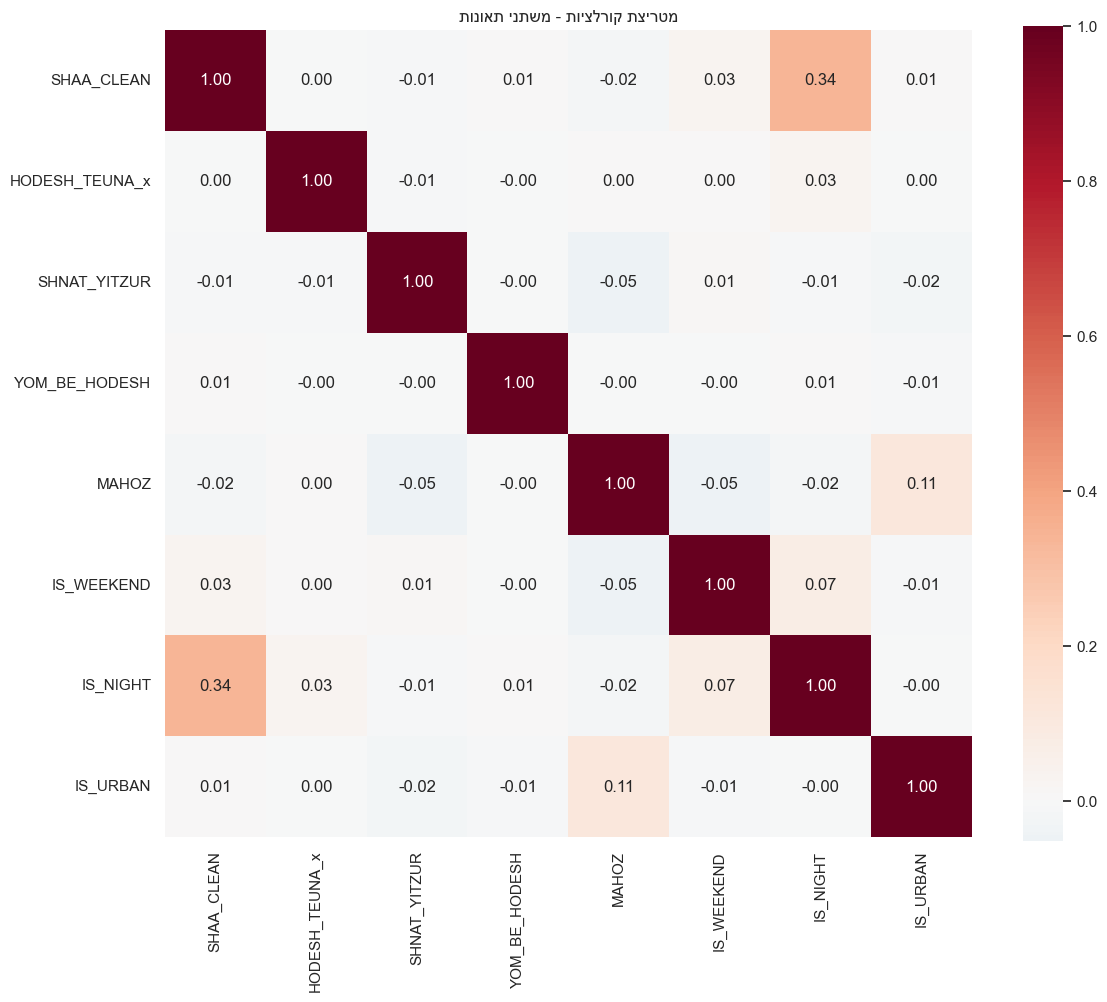

In [133]:
numeric_vars = ['SHAA_CLEAN', 'HODESH_TEUNA_x', 'SHNAT_YITZUR', 
                'YOM_BE_HODESH', 'MAHOZ']

# יצירת משתנים נוספים לניתוח
accdata['IS_WEEKEND'] = accdata['YOM_BASHAVUA'].isin(['ישיש', 'תבש']).astype(int)
accdata['IS_NIGHT'] = (accdata['YOM_LAYLA'] == 'לילה').astype(int)
accdata['IS_URBAN'] = accdata['SUG_DEREH'].isin(['עירוני לא-בצומת', 'עירוני בצומת']).astype(int)

# הוספת המשתנים החדשים
numeric_vars.extend(['IS_WEEKEND', 'IS_NIGHT', 'IS_URBAN'])

# חישוב מטריצת קורלציות
correlation_matrix = accdata[numeric_vars].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='RdBu_r', 
            center=0,
            square=True,
            fmt='.2f')
plt.title(reshape_hebrew('מטריצת קורלציות - משתני תאונות'))
plt.tight_layout()
plt.show()

📊 הקורלציות החזקות שמצאנו:

## 📊 הקורלציות החזקות שמצאנו:

### 🌙 שעה ולילה (0.34)
- ככל שהשעה מאוחרת יותר, יותר סיכוי שזה לילה
- **מעשי:** תאונות לילה מתרכזות בשעות מאוחרות (הגיוני)

### 🎯 סוף שבוע ולילה (0.07)
- קורלציה חלשה אבל חיובית
- **מעשי:** בסופי שבוע יש מעט יותר תאונות לילה

### 🏙️ מחוז ועירוני (0.11)
- יש הבדל קל בין מחוזות בסוג הדרכים
- **מעשי:** חלק מהמחוזות יותר דרכים עירוניים מאחרים

## 💡 מה זה אומר לנו:

### ✅ דברים טובים:
- המשתנים שיצרנו עובדים נכון
- אין קורלציות חזקות מדי (מעל 0.5) - זה טוב לניתוח
- הקשרים הגיוניים ומצפויים

### ⚠️ מגבלות המדגם:
- רוב הקורלציות קרובות לאפס (לבן במטריצה)
- המשתנים די עצמאיים זה מזה
- אין הרבה דפוסים חזקים

## 🎯 המסקנות המעשיות:

1. **תאונות לילה** מתרכזות בשעות מאוחרות (ברור)
2. **סופי שבוע** מעט יותר מסוכנים בלילה
3. **מחוזות שונים** עם דפוסים שונים של דרכים עירוניות

## 🔍 למה כדאי להתמקד:

- **ניתוח זמנים:** שעות לילה בסופי שבוע
- **הבדלים גיאוגרפיים:** השוואה בין מחוזות
- **דפוסי התנהגות:** מה קורה בשעות שונות

## סיכום:
הנתונים נקיים ומאורגנים, המשתנים עובדים טוב, ויש כמה דפוסים מעניינים לחקור יותר לעומק!

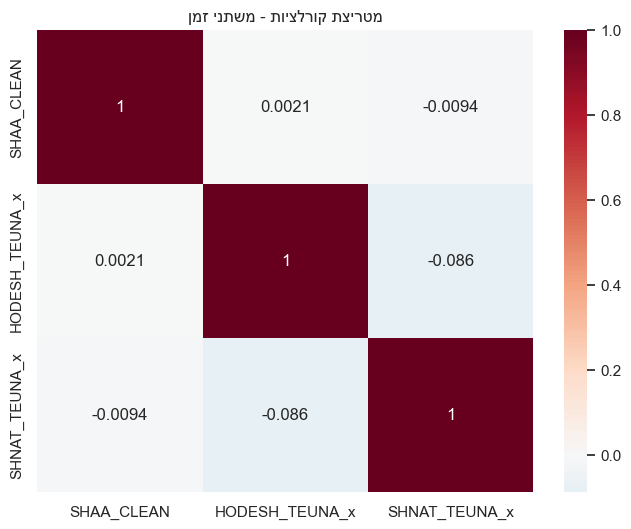

In [139]:
# ניתוח קורלציה בין שעה, חודש ומספר תאונות

correlation_data = accdata[['SHAA_CLEAN', 'HODESH_TEUNA_x', 'SHNAT_TEUNA_x']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_data, annot=True, cmap='RdBu_r', center=0)
plt.title(reshape_hebrew('מטריצת קורלציות - משתני זמן'))
plt.show()

כדי להעתיק את התוכן שלי בפורמט Markdown נקי, פשוט העתק את הטקסט הזה:
markdown## סיכום מטריצת הקורלציות - משתני זמן

### 📊 מה אנחנו רואים במטריצה:

**🕐 SHAA_CLEAN (שעת התאונה):**
- קורלציה עם עצמה: 1.0 (ברור)
- קורלציה עם חודש: 0.0021 (כמעט אפס)
- קורלציה עם שנה: -0.0094 (כמעט אפס)

**📅 HODESH_TEUNA_x (חודש התאונה):**
- קורלציה עם שעה: 0.0021 (כמעט אפס)
- קורלציה עם עצמו: 1.0 (ברור)
- קורלציה עם שנה: -0.086 (חלשה ושלילית)

**📆 SHNAT_TEUNA_x (שנת התאונה):**
- קורלציה עם שעה: -0.0094 (כמעט אפס)
- קורלציה עם חודש: -0.086 (חלשה ושלילית)
- קורלציה עם עצמה: 1.0 (ברור)

### 💡 מה זה אומר במילים פשוטות:

**🎯 העיקר:**
- **אין קשר בין שעת היום לחודש** - תאונות קורות בכל שעה בכל חודש
- **אין קשר בין שעת היום לשנה** - דפוסי השעות לא השתנו בין השנים
- **יש קשר חלש ושלילי בין חודש לשנה** - אולי שינויים קלים בדפוסים החודשיים

**🔍 המשמעות המעשית:**

1. **עצמאות זמנית:** השעה, החודש והשנה עצמאיים זה מזה
2. **יציבות דפוסים:** דפוסי התאונות לא השתנו משמעותית בין השנים

### ✅ למה זה טוב:

- **לעבודה שלנו:** המשתנים הזמניים עצמאיים ולא משפיעים זה על זה
- **לניתוח:** אפשר לנתח כל משתנה זמני בנפרד
- **לאמינות:** הנתונים לא מוטים לטובת זמנים מסוימים


# התפלגות סוגי התאונות על פני שלושת השנים 2021-2023

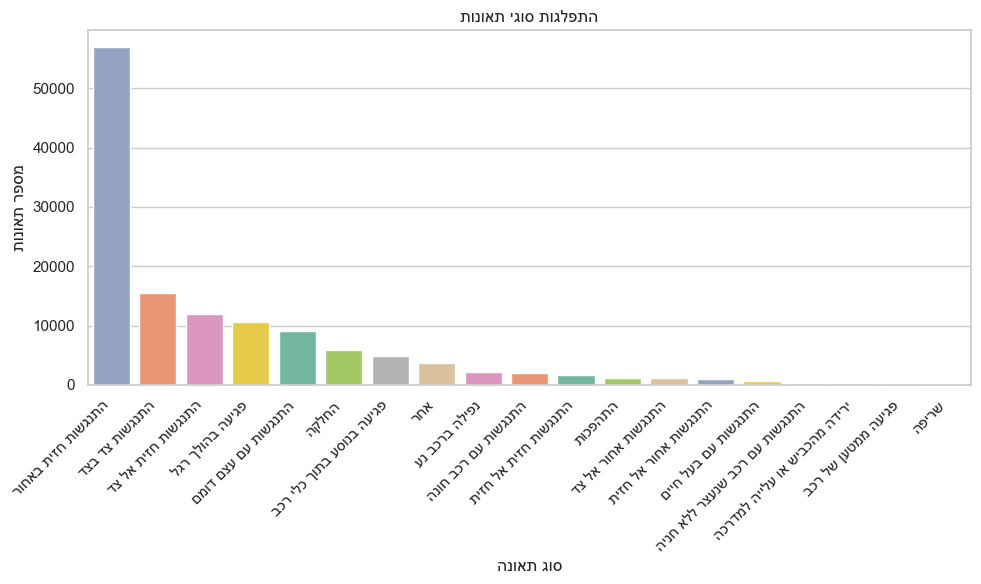

In [157]:

# עיצוב גרפים
sns.set(style="whitegrid", font="Arial")
plt.rcParams['axes.unicode_minus'] = False

# פונקציה לעיבוד טקסטים בעברית
def reshape_hebrew(text):
    return get_display(arabic_reshaper.reshape(str(text)))

# ווידוא קיום DataFrame
assert 'accdata' in locals(), "DataFrame בשם accdata לא מוגדר"

# סינון ערכים חסרים
accdata = accdata[accdata['SUG_TEUNA'].notna()].copy()

# יצירת מילון ערכים מעובדים רק על ערכים ייחודיים
unique_vals = accdata['SUG_TEUNA'].unique()
hebrew_map = {val: reshape_hebrew(val) for val in unique_vals}

# החלפת הערכים לפי המילון
accdata['SUG_TEUNA_HE'] = accdata['SUG_TEUNA'].map(hebrew_map)

# עיבוד טקסטים לצירים
title = reshape_hebrew("התפלגות סוגי תאונות")
xlabel = reshape_hebrew("סוג תאונה")
ylabel = reshape_hebrew("מספר תאונות")

# יצירת גרף
plt.figure(figsize=(10, 6))
sns.countplot(
    data=accdata,
    x='SUG_TEUNA_HE',
    hue='SUG_TEUNA_HE',  # מוודא שכל עמודה תקבל צבע משלה
    order=accdata['SUG_TEUNA_HE'].value_counts().index,
    palette='Set2',
    legend=False
)
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

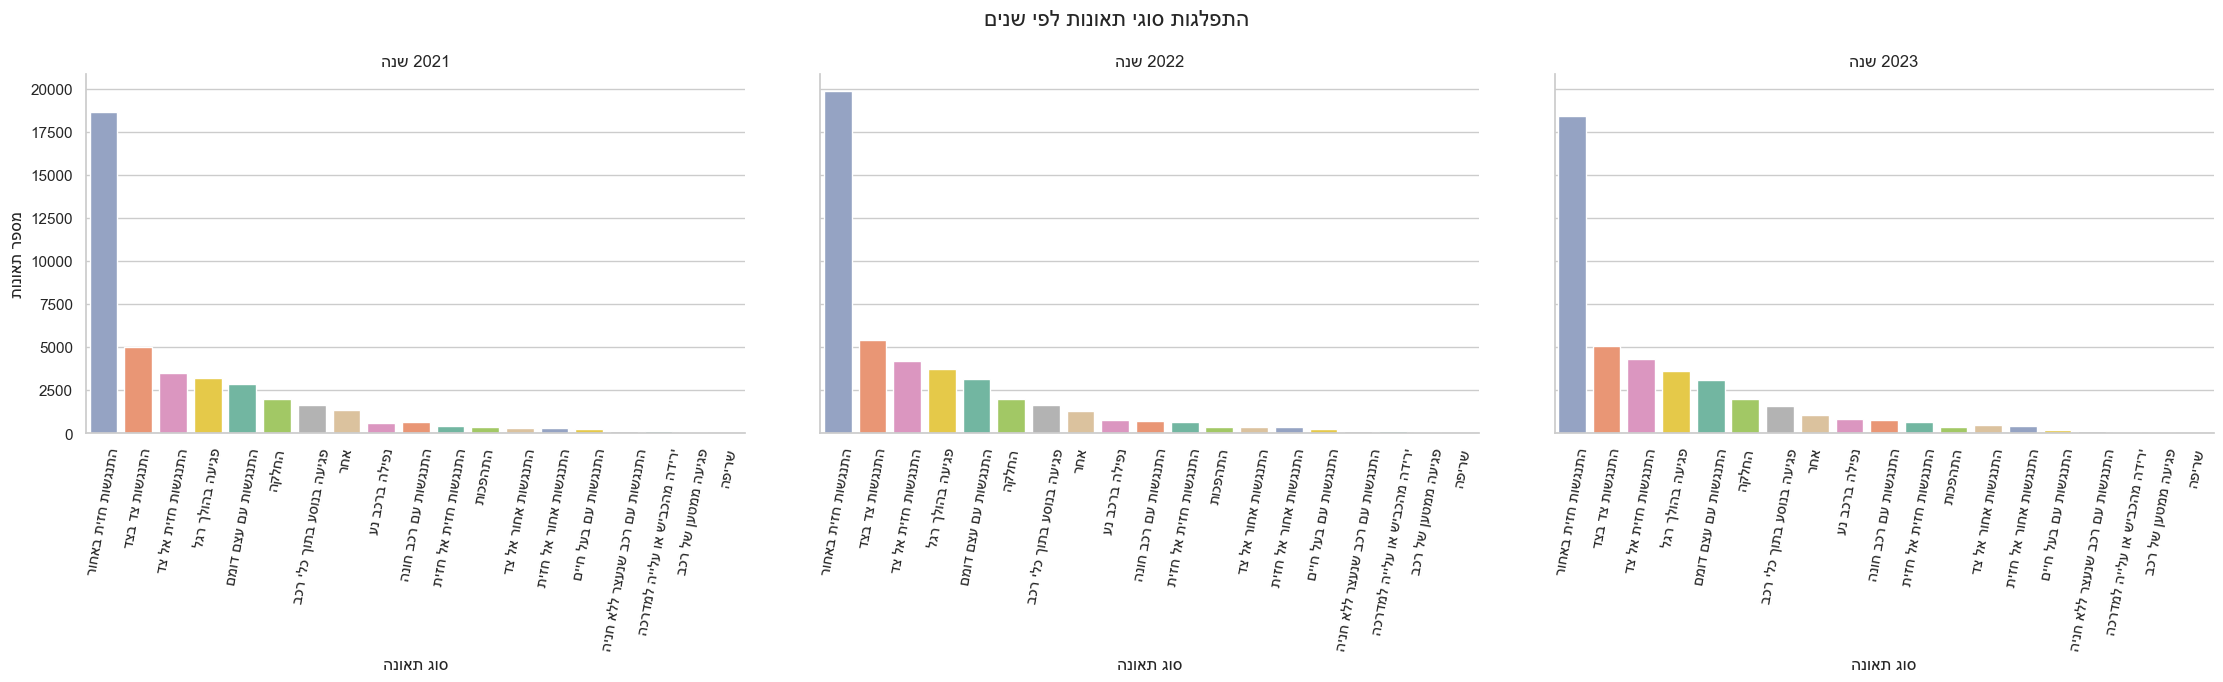

In [54]:

# עיצוב גרפים
sns.set(style="whitegrid", font="Arial")
plt.rcParams['axes.unicode_minus'] = False

# כותרות גרף
title = reshape_hebrew("התפלגות סוגי תאונות לפי שנים")
xlabel = reshape_hebrew("סוג תאונה")
ylabel = reshape_hebrew("מספר תאונות")
col_title = reshape_hebrew("שנה")

# בדיקה שעמודות קיימות
if 'SHNAT_TEUNA_x' in accdata.columns and 'SUG_TEUNA' in accdata.columns:
    # סינון שורות עם ערכים חסרים
    accdata = accdata[accdata['SUG_TEUNA'].notna()].copy()

    # עיבוד טקסטים בעברית רק פעם אחת (מיפוי)
    unique_vals = accdata['SUG_TEUNA'].unique()
    teuna_map = {val: reshape_hebrew(val) for val in unique_vals}
    accdata['SUG_TEUNA_HE'] = accdata['SUG_TEUNA'].map(teuna_map)

    # עיבוד שנה למחרוזת
    accdata['SHNAT_TEUNA_x'] = accdata['SHNAT_TEUNA_x'].astype(str)

    # גרף
    g = sns.catplot(
        data=accdata,
        x='SUG_TEUNA_HE',
        hue='SUG_TEUNA_HE',
        kind='count',
        col='SHNAT_TEUNA_x',
        col_wrap=3,
        height=5,
        aspect=1.5,
        order=accdata['SUG_TEUNA_HE'].value_counts().index,
        palette='Set2',
        legend=False
    )
    g.set_titles(col_template=col_title + " {col_name}")
    g.set_axis_labels(xlabel, ylabel)

    for ax in g.axes.flat:
        ax.tick_params(axis='x', rotation=80)

    plt.subplots_adjust(top=0.85)
    g.fig.suptitle(title, fontsize=16)
    plt.show()
else:
    print("אחת מהעמודות SHNAT_TEUNA_x או SUG_TEUNA לא קיימת.")


### 🔹  מהו סוג התאונה הנפוץ ביותר?

#### ✅ מסקנה:
הנתונים מצביעים על כך ש־**"פגיעת חזית באחור"** ו־**"התנגשות צד"** הן התאונות הנפוצות ביותר לאורך שלושת השנים

#### 📌 השלכות:
יש להמשיך לחנך נהגים לשמירת מרחק, הימנעות מהסחות דעת, ושמירה על עירנות 

---


# האם שנת הייצור של הרכב הוא הגורם לתאונה ? רכב ישן או חדש ?

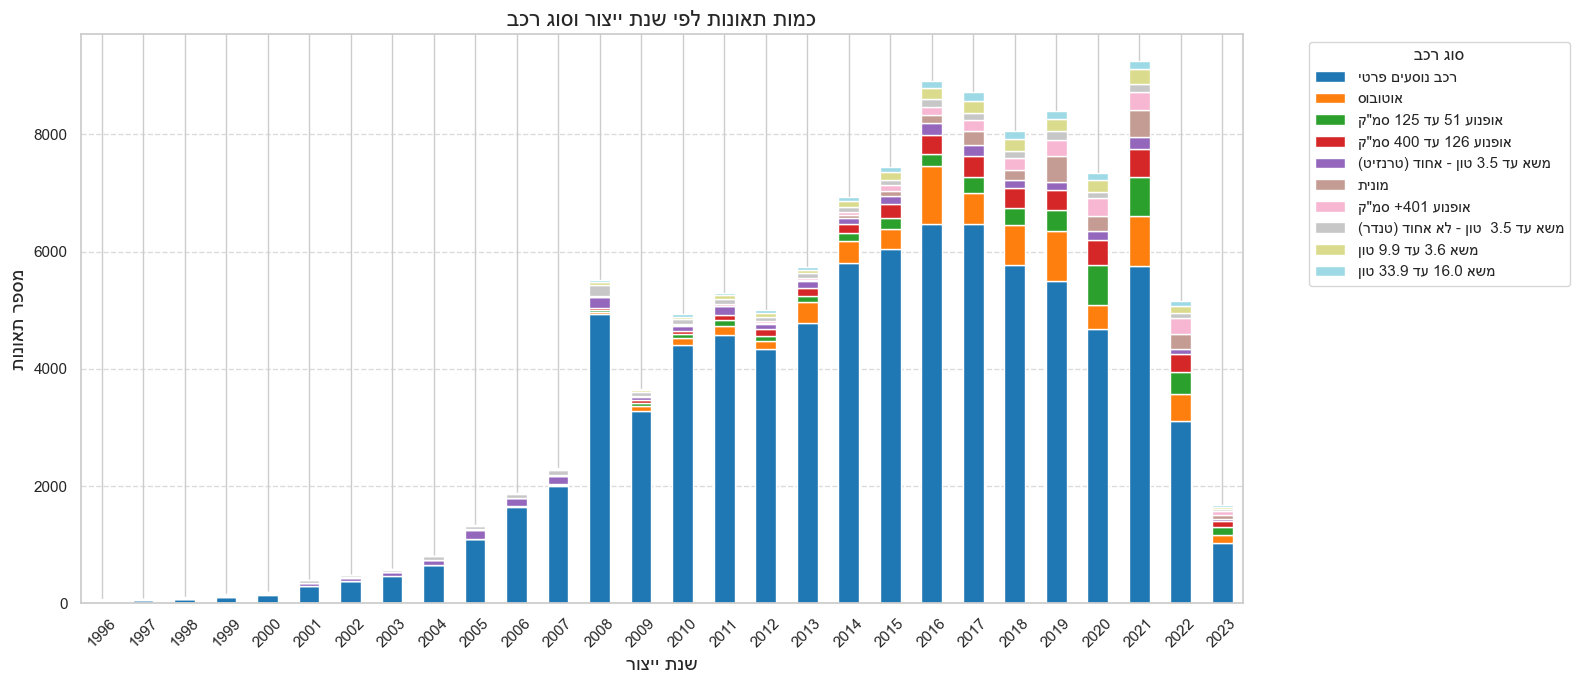

In [161]:
import numpy as np

# סינון נתונים חסרים ושלא דווח מה שנת החחצור של כלי הרכב
df = accdata[(accdata['SHNAT_YITZUR'] != 0) & accdata['SHNAT_YITZUR'].notna() & accdata['SUG_REHEV_LMS'].notna()]

# קיבוץ וספירת תאונות לפי שנת ייצור וסוג רכב
pivot_data = df.pivot_table(index='SHNAT_YITZUR',
                            columns='SUG_REHEV_LMS',
                            values='pk_teuna_fikt',
                            aggfunc='count',
                            fill_value=0)

# מיון השנים בסדר עולה
pivot_data = pivot_data.sort_index()

# בחירת 10 סוגי רכב עם נפח גבוה ביותר
top_vehicles = pivot_data.sum().sort_values(ascending=False).head(10).index
pivot_data_top = pivot_data[top_vehicles]

# סינון שנים ללא תאונות בכלל
pivot_data_top = pivot_data_top.loc[~(pivot_data_top == 0).all(axis=1)]

# סינון שנים מ-1996 ואילך
pivot_data_top = pivot_data_top.loc[pivot_data_top.index >= 1996]

# ציור גרף עמודות מקוננות (stacked bar plot)
ax = pivot_data_top.plot(kind='bar', stacked=True, figsize=(16,7), colormap='tab20')
ax.set_xticks(np.arange(len(pivot_data_top.index)))
ax.set_xticklabels([int(year) for year in pivot_data_top.index])

# תיקון טקסט בעברית במקרא (legend)
handles, labels = ax.get_legend_handles_labels()
new_labels = [reshape_hebrew(label) for label in labels]
ax.legend(handles, new_labels, title=reshape_hebrew('סוג רכב'), bbox_to_anchor=(1.05, 1), loc='upper left')

# כותרות בצירים וגריד
plt.title(reshape_hebrew('כמות תאונות לפי שנת ייצור וסוג רכב'), fontsize=16)
plt.xlabel(reshape_hebrew('שנת ייצור'), fontsize=14)
plt.ylabel(reshape_hebrew('מספר תאונות'), fontsize=14)
plt.xticks(rotation=45)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<img src="https://raw.githubusercontent.com/MaorWN/FirstL/main/car.jpg" width="600">

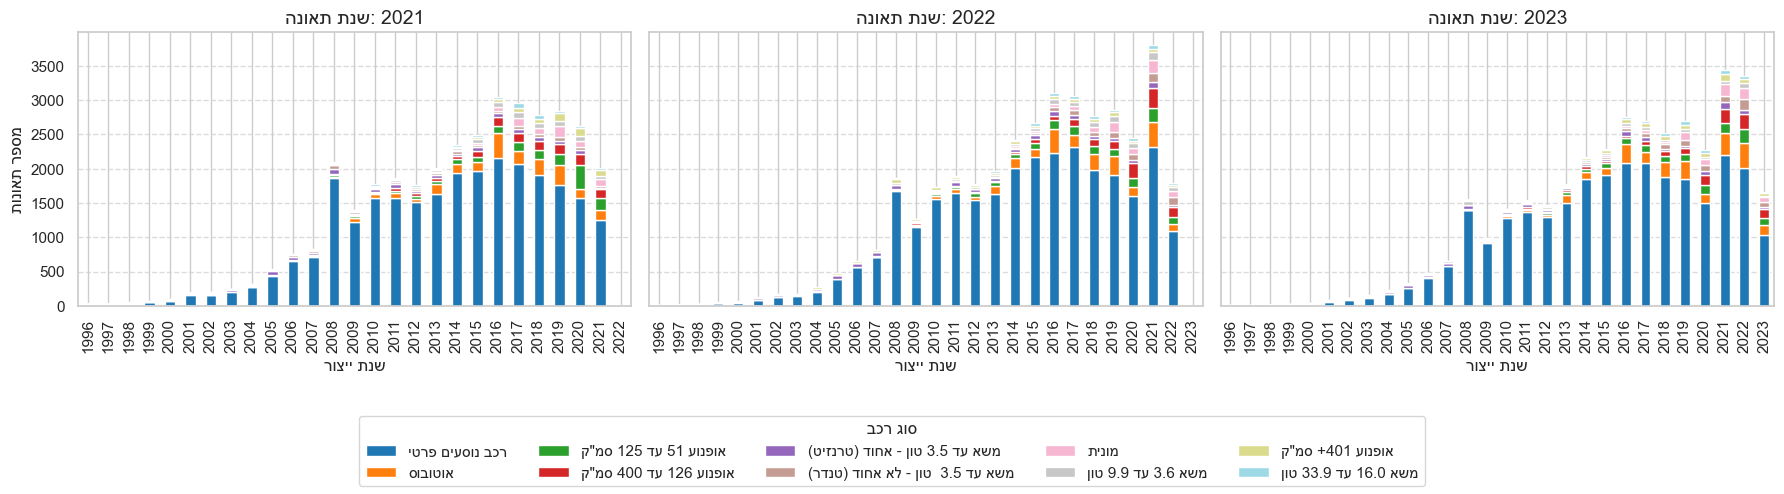

In [164]:

# נניח accdata כבר קיים וכולל את העמודה SHNAT_TEUNA_x
years = sorted(accdata['SHNAT_TEUNA_x'].dropna().unique())
num_years = len(years)
col_title = reshape_hebrew("שנת תאונה")

# הגבלת מספר גרפים (אפשר להתאים)
max_plots = 9
years_to_plot = years[:max_plots]

# קביעת גודל המטריצה של הגרפים (3 עמודות, כמה שורות)
cols = 3
rows = int(np.ceil(len(years_to_plot) / cols))

fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 5), sharey=True)

# "שטוח" את מערך הצירים למקרה של שורה אחת בלבד
axes = axes.flatten() if num_years > 1 else [axes]

for i, year in enumerate(years_to_plot):
    ax = axes[i]
    # סינון לפי שנת תאונה
    df_year = accdata[(accdata['SHNAT_TEUNA_x'] == year) & 
                      (accdata['SHNAT_YITZUR'] != 0) & 
                      accdata['SHNAT_YITZUR'].notna() & 
                      accdata['SUG_REHEV_LMS'].notna()]

    # קיבוץ וספירה
    pivot_data = df_year.pivot_table(index='SHNAT_YITZUR',
                                     columns='SUG_REHEV_LMS',
                                     values='pk_teuna_fikt',
                                     aggfunc='count',
                                     fill_value=0)

    pivot_data = pivot_data.sort_index()
    top_vehicles = pivot_data.sum().sort_values(ascending=False).head(10).index
    pivot_data_top = pivot_data[top_vehicles]
    pivot_data_top = pivot_data_top.loc[~(pivot_data_top == 0).all(axis=1)]
    pivot_data_top = pivot_data_top.loc[pivot_data_top.index >= 1996]

    # ציור גרף מקונן
    pivot_data_top.plot(kind='bar', stacked=True, ax=ax, colormap='tab20')
    ax.set_xticks(np.arange(len(pivot_data_top.index)))
    ax.set_xticklabels([int(year) for year in pivot_data_top.index])


    # כותרות
    ax.set_title(f"{reshape_hebrew('שנת תאונה')}: {year}", fontsize=14)
    ax.set_xlabel(reshape_hebrew('שנת ייצור'))
    ax.set_ylabel(reshape_hebrew('מספר תאונות'))
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.legend([],[], frameon=False)  # במקרא כללי מתחת

# הסרת צירים ריקים במידה ויש פחות גרפים מ-max_plots
for j in range(len(years_to_plot), len(axes)):
    fig.delaxes(axes[j])

# מקרא אחד מרכזי מתחת לכל הגרפים
handles, labels = axes[0].get_legend_handles_labels()
new_labels = [reshape_hebrew(label) for label in labels]
fig.legend(handles, new_labels, title=reshape_hebrew('סוג רכב'), loc='lower center', ncol=5)

plt.tight_layout(rect=[0, 0.2, 1, 1])
plt.show()

#### 🧠 מה אפשר להסיק מהגרף?
> 1. הכלים החדשים מעורבים יותר בתאונות
ברוב שנות התאונה (2021–2023), רואים שמרבית כלי הרכב המעורבים בתאונות יוצרו בעשור האחרון (2010 ואילך), ובעיקר בשנים האחרונות (2016–2021).
> - זה טבעי, כי רוב הרכבים שנמצאים על הכביש כיום הם רכבים חדשים יחסית.
> 2. שכיחות גבוהה לרכב פרטי
הצבע הכחול (רכב נוסעים פרטי) שולט ברוב העמודות, כלומר רוב התאונות כוללות רכבים פרטיים.
> - זה תואם את שיעור הרכבים הפרטיים בצי הרכב הכללי.
> 3. מספר תאונות כולל – מגמה יציבה או עולה
> - ניתן לראות שב-2022 ובמיוחד ב-2023 יש ירידה במספר כלי הרכב המעורבים בתאונות דרכים קלות לעומת 2021, בעיקר בקרב רכבים שיוצרו ב-2016 ואילך.
> 4. נוכחות גבוהה של רכבים ישנים (לפני 2005) – כמעט לא קיימת
> - רכבים שיוצרו לפני 2005 נדירים יחסית בתאונות, מה שכנראה מעיד על כך שרובם כבר לא בשימוש.
> 5. סוגי רכבים מיוחדים (אוטובוסים, משאיות כבדות, אופנועים) – נוכחות מצומצמת אך עקבית
מופיעים פחות, אך ניתן לראות שכבות דקות שלהם, בעיקר בשנים האחרונות.
> - ייתכן שתחבורה מקצועית/ציבורית גם משפיעה אך לא בהיקפים כמו רכב פרטי.

#### 🔎 מסקנות כלליות:
- רוב הרכבים המעורבים בתאונות הם בני פחות מ-10 שנים.

- רכב פרטי הוא הסוג הדומיננטי בתאונות.

- תאונות עם רכבים ישנים נדירות – אולי עקב ירידה בכמותם על הכביש.

# 🔹  האם יש קשר בין סוג הרכב לאזור גאוגרפי של התאונה? 

In [170]:

# סינון נתונים עם קואורדינטות תקינות
df = accdata.copy()
df = df.dropna(subset=['X', 'Y', 'SUG_REHEV_LMS', 'SUG_TEUNA_HE', 'SHNAT_TEUNA_y'])
df = df[(df['X'] > 100000) & (df['X'] < 300000) & (df['Y'] > 500000) & (df['Y'] < 800000)]

# המרת קואורדינטות מ־EPSG:2039 ל־EPSG:4326
transformer = Transformer.from_crs("EPSG:2039", "EPSG:4326", always_xy=True)
df['lon'], df['lat'] = transformer.transform(df['X'].values, df['Y'].values)

# דגימה כדי למנוע עומס (אפשר להגדיל/להקטין לפי הצורך)
df_sample = df.sample(n=min(2000, len(df)), random_state=42)

# יצירת מפה בסיסית
m = folium.Map(location=[31.7683, 35.2137], zoom_start=8)

# מיפוי צבעים לפי סוג רכב
unique_vehicles = df_sample['SUG_REHEV_LMS'].unique()
colormap = matplotlib.colormaps.get_cmap('tab20')
color_dict = {veh: mcolors.to_hex(colormap(i % 20)) for i, veh in enumerate(unique_vehicles)}

# לולאה על השנים להצגת שכבות נפרדות
for year in sorted(df_sample['SHNAT_TEUNA_y'].unique()):
    # יצירת FeatureGroup לשנה
    fg = folium.FeatureGroup(name=f"שנה {int(year)}", show=True)
    
    # סינון הנתונים לאותה שנה
    df_year = df_sample[df_sample['SHNAT_TEUNA_y'] == year]
    
    # יצירת MarkerCluster בתוך ה-FeatureGroup
    marker_cluster = MarkerCluster().add_to(fg)
    
    # הוספת נקודות
    for _, row in df_year.iterrows():
        folium.CircleMarker(
            location=[row['lat'], row['lon']],
            radius=4,
            color=color_dict[row['SUG_REHEV_LMS']],
            fill=True,
            fill_color=color_dict[row['SUG_REHEV_LMS']],
            fill_opacity=0.7,
            popup=folium.Popup(
                f"""<div dir='rtl'>
                סוג רכב: {row['SUG_REHEV_LMS']}<br>
                שנה: {int(row['SHNAT_TEUNA_y'])}<br>
                סוג תאונה: {reshape_hebrew(row['SUG_TEUNA_HE'])}
                </div>""",
                max_width=300
            )
        ).add_to(marker_cluster)
    
    # הוספת HeatMap
    heat_data = df_year[['lat', 'lon']].values.tolist()
    HeatMap(heat_data, radius=8, blur=15).add_to(fg)
    
    # הוספת ה-FeatureGroup למפה
    fg.add_to(m)

# הוספת מקרא צבעים
legend_html = '''
<div style="position: fixed; bottom: 50px; left: 50px; z-index:9999; background-color:white; padding: 10px; border:2px solid grey;">
<b>מקרא: סוג רכב</b><br>
''' + ''.join([f'<div style="display:inline-block; width:10px; height:10px; background:{color_dict[veh]}; margin-right:5px;"></div> {veh}<br>' for veh in unique_vehicles]) + '</div>'

m.get_root().html.add_child(folium.Element(legend_html))

# הוספת בורר שכבות להפעלה וכיבוי של שנים
folium.LayerControl(collapsed=False).add_to(m)

# הצגת המפה
m

#### ✅ מסקנה:
> מהמפה ניתן לראות כי באזורים **מרכזיים וצפופים** (כגון תל אביב, ירושלים וחיפה) מספר כלי הרכב המעורבים בתאונות הוא **גבוה יותר**, ככל הנראה בשל **עומסי תנועה, ריכוז אוכלוסייה גבוה**, ושכיחות גבוהה יותר של כלי רכב.  
> עם זאת, לא ניתן להבחין ב־**מגמה ברורה** או קשר חד־משמעי בין **סוג הרכב** לבין **המיקום הגאוגרפי** של התאונה – ייתכן שנדרשת חקירה מעמיקה יותר תוך שילוב משתנים נוספים כמו שעות, סוגי דרכים, ותנאי דרך.


In [172]:
def fix_hebrew_plot_labels(ax):
  
    ticks = ax.get_yticks()
    ax.set_yticks(ticks)
    ax.set_yticklabels([f"{int(tick * 100)}%" for tick in ticks])
    
    # תיקון כותרת
    if ax.title.get_text():
        ax.set_title(reshape_hebrew(ax.title.get_text()))

    # תיקון תוויות צירים
    if ax.get_xlabel():
        ax.set_xlabel(reshape_hebrew(ax.get_xlabel()))
    if ax.get_ylabel():
        ax.set_ylabel(reshape_hebrew(ax.get_ylabel()))
    
    # תיקון טיקים בציר X
    xlabels = [reshape_hebrew(t.get_text()) for t in ax.get_xticklabels()]
    ax.set_xticklabels(xlabels, rotation=45)
    
    # תיקון טיקים בציר Y (אם רוצים)
    ylabels = [reshape_hebrew(t.get_text()) for t in ax.get_yticklabels()]
    ax.set_yticklabels(ylabels)
    
    # תיקון תוויות מקרא (legend)
    leg = ax.get_legend()
    if leg:
        for text in leg.get_texts():
            text.set_text(reshape_hebrew(text.get_text()))
        # אם יש כותרת למקרא, גם לה לעבד
        if leg.get_title():
            leg.set_title(reshape_hebrew(leg.get_title().get_text()))

#  שכיחויות של סוגי תאונה לפי סוג כביש

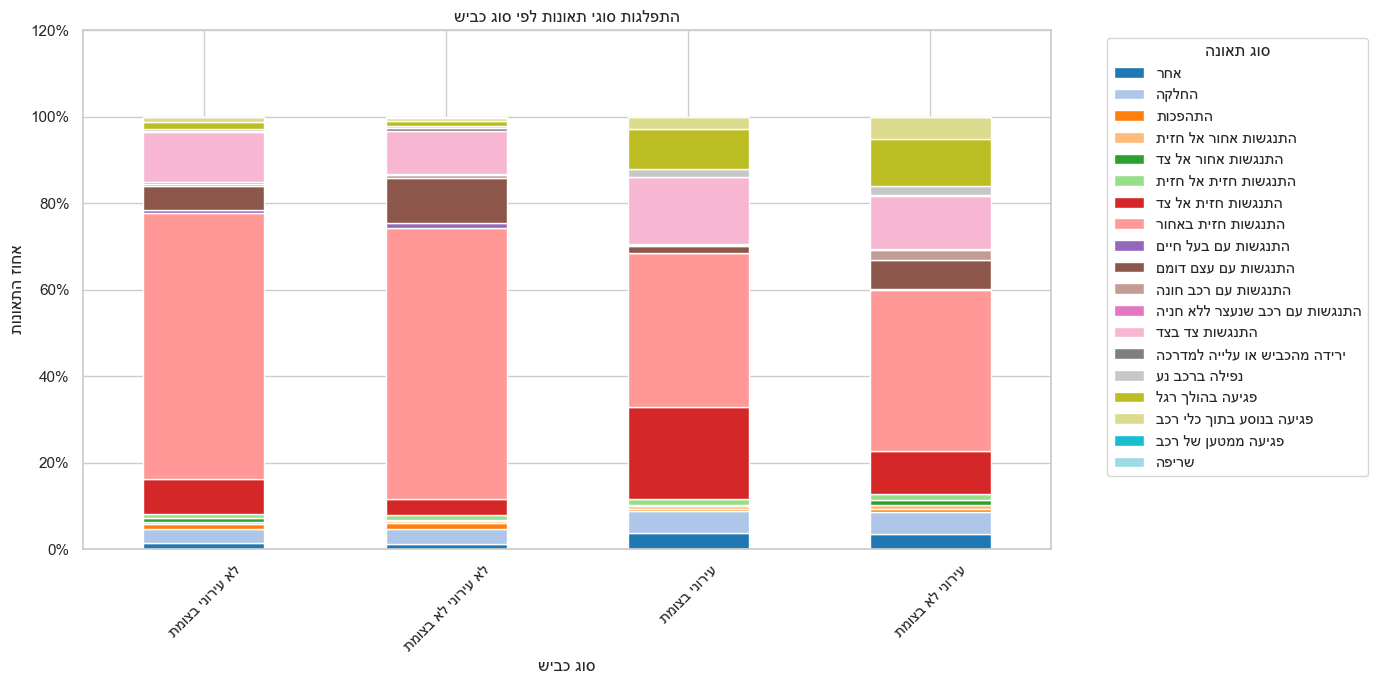

In [175]:
# טבלת שכיחויות של סוגי תאונה לפי סוג כביש
cross_tab = pd.crosstab(accdata['SUG_DEREH'], accdata['SUG_TEUNA'])

#print(cross_tab)

# גרף עמודות מצטבר להצגת התפלגות
cross_tab_norm = cross_tab.div(cross_tab.sum(axis=1), axis=0)  # אחוזים לכל סוג כביש

ax = cross_tab_norm.plot(kind='bar', stacked=True, figsize=(14,7), colormap='tab20')

plt.title('התפלגות סוגי תאונות לפי סוג כביש')
plt.xlabel('סוג כביש')
plt.ylabel('אחוז התאונות')
plt.legend(title='סוג תאונה', bbox_to_anchor=(1.05, 1), loc='upper left')

fix_hebrew_plot_labels(ax)

plt.tight_layout()
plt.show()


#### ✅ מסקנה:
> מהניתוח עולה כי קיימת **התפלגות שונה של סוגי תאונות** בהתאם ל־**סוג הדרך**:
> - ב־**כבישים עירוניים** נפוצות יותר **התנגשויות בין כלי רכב**, תאונות עם **הולכי רגל**, ופגיעות כתוצאה מחוסר זהירות בשטח צפוף.  
> - ב־**כבישים בינעירוניים**  נרשמות יותר **תאונות חזית־אחור** – לעיתים עקב מהירות גבוהה, עייפות או הסחות דעת.


#### 📌 השלכות:
- 🚧 יש **להתאים את אמצעי הבטיחות והתשתיות** לאופי התאונות בכל סוג כביש:
  - בעיר: שיפור מעברי חצייה, רמזורים חכמים, הגבלת מהירות.
  - בינעירוני: שילוט ברור, פסי האטה לפני פניות מסוכנות, מצלמות מהירות.
- 🛑 קמפיינים ממוקדים להגברת מודעות לנהיגה בטוחה לפי סוג הכביש


---
### <span style="color:green"> Observation 2:</span>

>
> 
>
> 


---


### 🔹  איזה ימים בשבוע מסוכנים יותר?



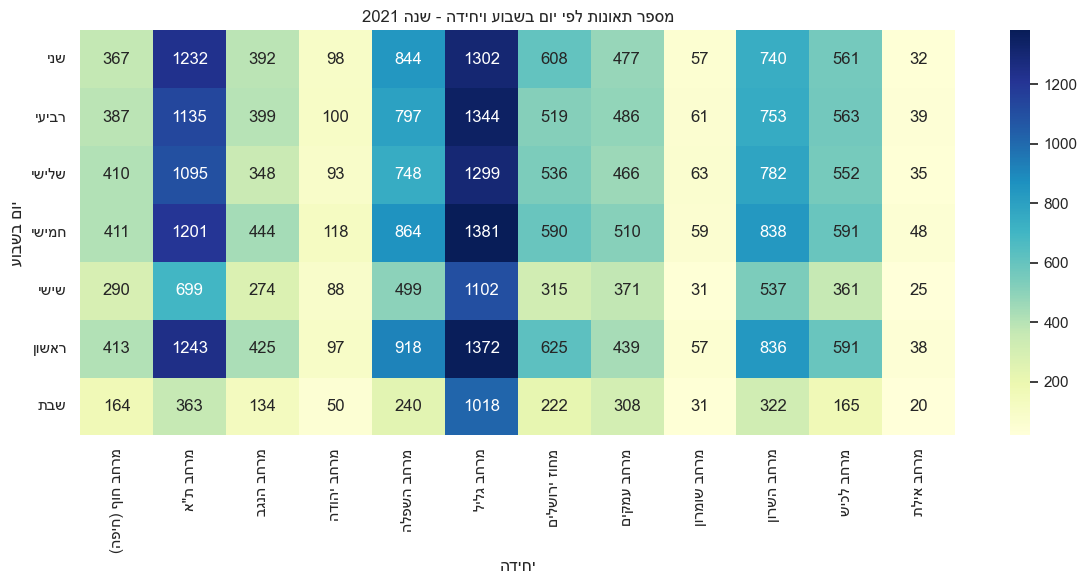

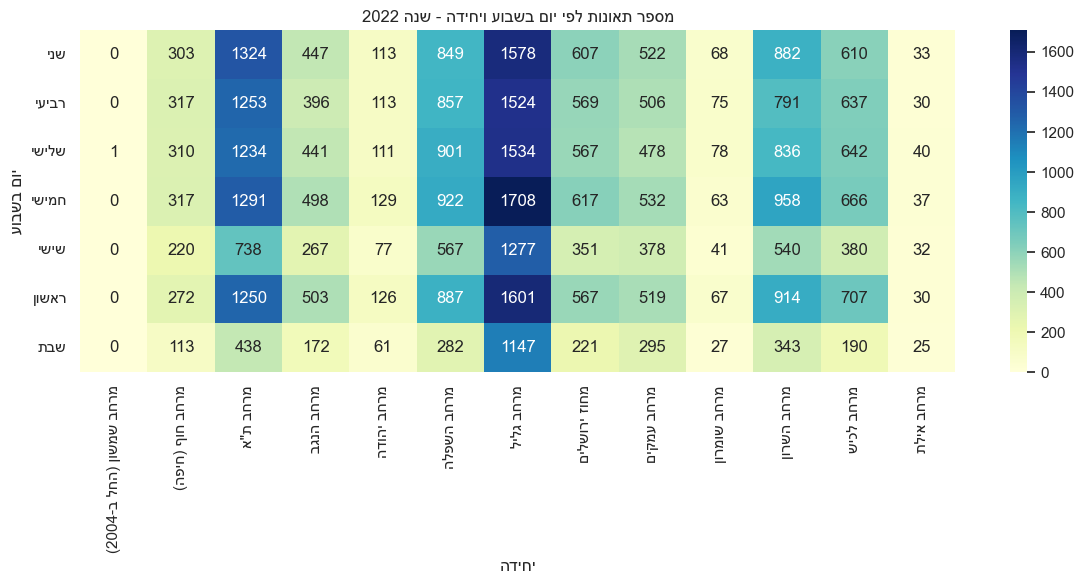

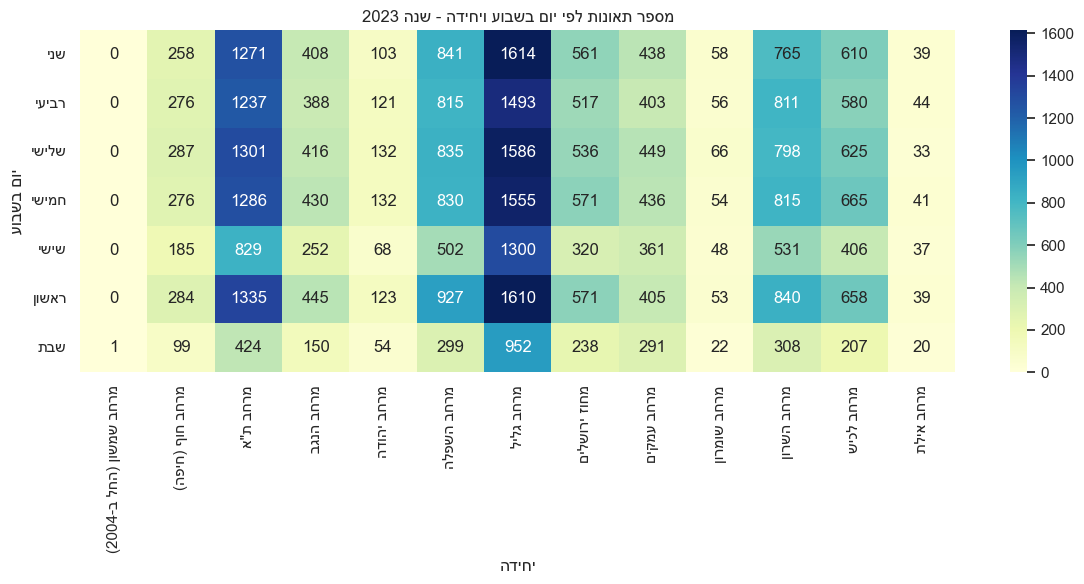

In [187]:
# עיבוד רק על הערכים הייחודיים בעמודות, ולא על כל השורות
unique_yom = accdata['YOM_BASHAVUA'].dropna().unique()
reshaped_yom = {val: reshape_hebrew(val) for val in unique_yom}
accdata['YOM_BASHAVUA'] = accdata['YOM_BASHAVUA'].map(reshaped_yom).fillna(accdata['YOM_BASHAVUA'])

unique_yehida = accdata['YEHIDA'].dropna().unique()
reshaped_yehida = {val: reshape_hebrew(val) for val in unique_yehida}
accdata['YEHIDA'] = accdata['YEHIDA'].map(reshaped_yehida).fillna(accdata['YEHIDA'])


# המרת השנה למחרוזת (לשימוש ב־facet)
accdata['SHNAT_TEUNA_x'] = accdata['SHNAT_TEUNA_x'].astype(str)

# יצירת הדוח המורחב - ספירת תאונות לפי שנה, יום בשבוע ויחידה
report = accdata.groupby(['SHNAT_TEUNA_x', 'YOM_BASHAVUA', 'YEHIDA']).size().reset_index(name='מספר תאונות')

# ניצור FacetGrid עם heatmap נפרד לכל שנה
for year in report['SHNAT_TEUNA_x'].unique():
    subset = report[report['SHNAT_TEUNA_x'] == year]
    pivot_report = subset.pivot(index=reshape_hebrew('YOM_BASHAVUA'), columns='YEHIDA', values='מספר תאונות').fillna(0)
    
    plt.figure(figsize=(12, 6))
    sns.heatmap(pivot_report, annot=True, fmt=".0f", cmap="YlGnBu")
    plt.title(reshape_hebrew(f"מספר תאונות לפי יום בשבוע ויחידה - שנה {year}"))
    plt.xlabel(reshape_hebrew("יחידה"))
    plt.ylabel(reshape_hebrew("יום בשבוע"))
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


#### ✅ מסקנה:
מהמטריצת החום ניתן לראות דפוסים ברורים של תאונות לפי ימי השבוע במרחבים השונים, כאשר יש ימים בולטים כמו ראשון וחמישי עם שיעור תאונות גבוה מהרגיל.

#### 📌 השלכות:
זיהוי הימים המסוכנים יותר יכול לסייע להכוונת משאבי האכיפה, תכנון פעולות הסברה, ותגבור הכוחות בשעות וימים מועדים לפורענות.


# 🔹  איזה יחידות משטרה לפי מחוז מתמודדות עם עומס תאונות גבוה?

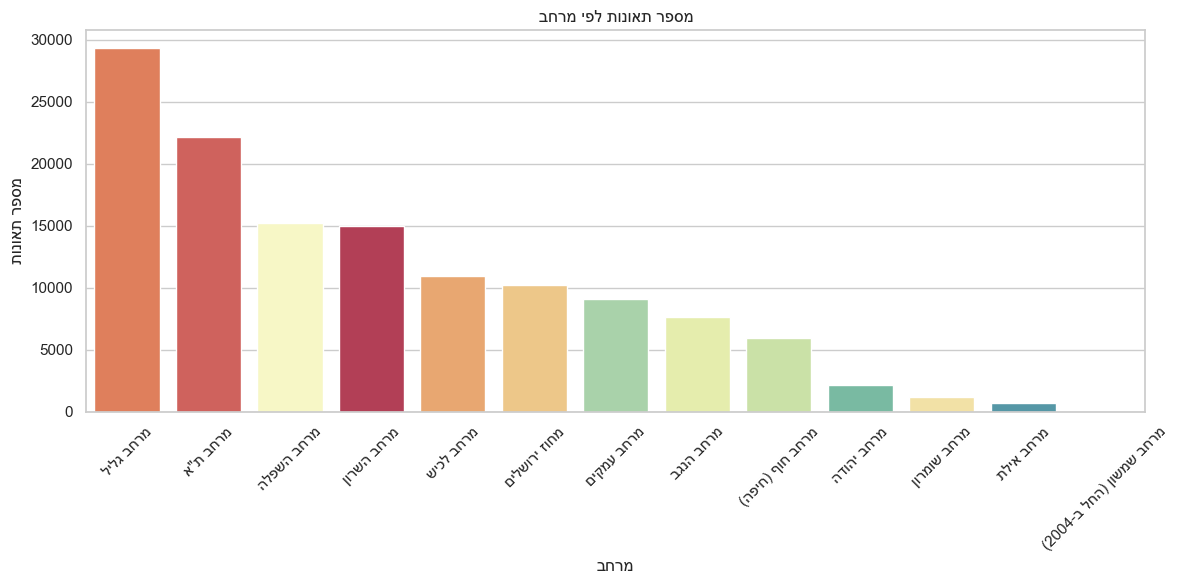

In [190]:
plt.figure(figsize=(12, 6))
sns.countplot(data=accdata, x='YEHIDA', order=accdata['YEHIDA'].value_counts().index, palette='Spectral',hue=reshape_hebrew('YEHIDA'),legend=False )
plt.title(reshape_hebrew("מספר תאונות לפי מרחב"))
plt.xlabel(reshape_hebrew("מרחב"))
plt.ylabel(reshape_hebrew("מספר תאונות"))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1400x800 with 0 Axes>

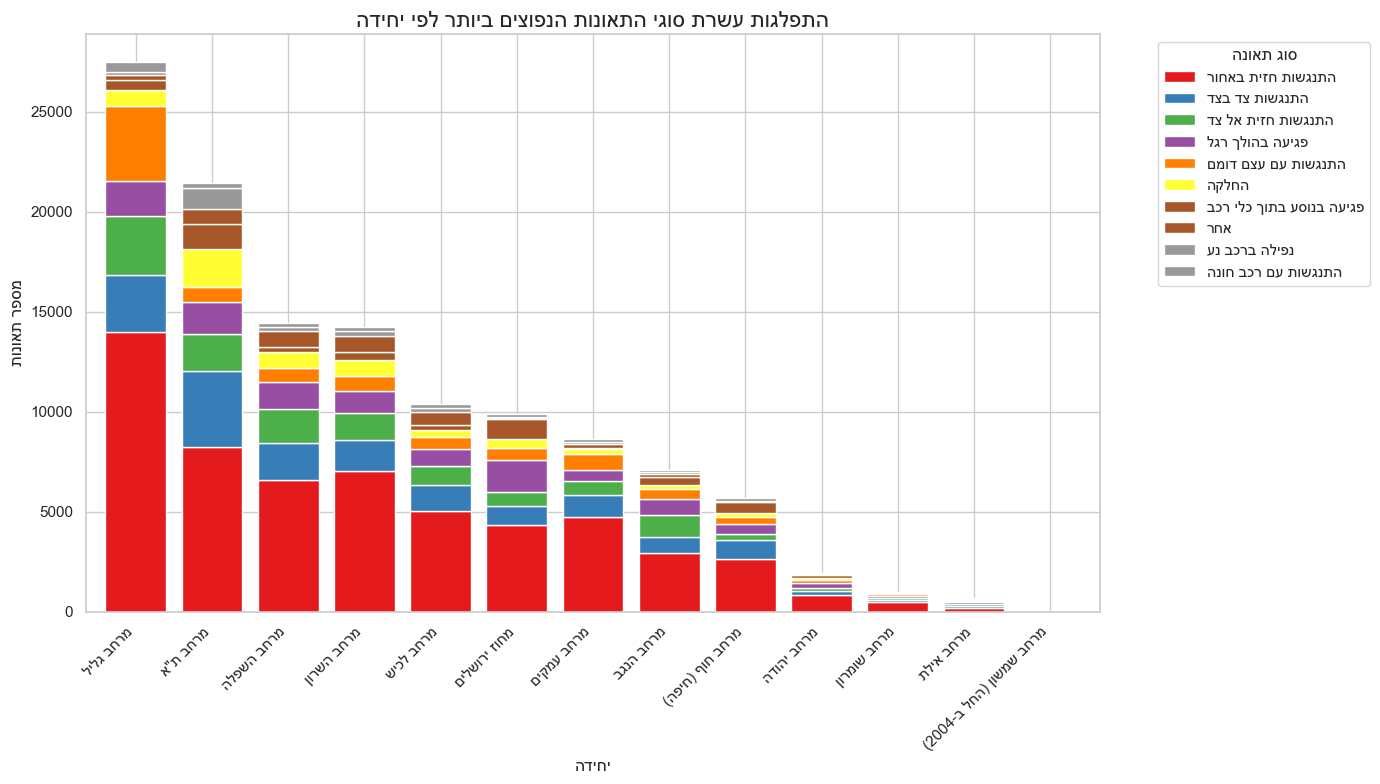

In [196]:
plt.figure(figsize=(14, 8))

# מציאת 10 סוגי התאונות הכי נפוצים
top_10_teuna_types = accdata['SUG_TEUNA_HE'].value_counts().head(10).index

# סינון הנתונים רק לסוגי התאונות הנפוצים
filtered_data = accdata[accdata['SUG_TEUNA_HE'].isin(top_10_teuna_types)]

# יצירת crosstab
cross_tab = pd.crosstab(filtered_data['YEHIDA'], filtered_data['SUG_TEUNA_HE'])

# סידור היחידות לפי סך התאונות
yehida_order = filtered_data['YEHIDA'].value_counts().index
cross_tab_ordered = cross_tab.loc[yehida_order]

# סידור סוגי התאונות לפי תכיפות
teuna_order = filtered_data['SUG_TEUNA_HE'].value_counts().index
cross_tab_ordered = cross_tab_ordered[teuna_order]

# יצירת גרף מוערם
ax = cross_tab_ordered.plot(kind='bar', stacked=True, figsize=(14, 8), 
                           colormap='Set1', width=0.8)

plt.title(reshape_hebrew("התפלגות עשרת סוגי התאונות הנפוצים ביותר לפי יחידה"), fontsize=16)
plt.xlabel(reshape_hebrew("יחידה"), fontsize=12)
plt.ylabel(reshape_hebrew("מספר תאונות"), fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title=reshape_hebrew("סוג תאונה"), bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [198]:
pivot_report = accdata.groupby(['YOM_BASHAVUA', 'YEHIDA']).size().unstack(fill_value=0)
pivot_report

# עיבוד אינדקס (שורות)
pivot_report.index = pivot_report.index.map(reshape_hebrew)

# עיבוד עמודות (אם הן קטגוריות בעברית)
pivot_report.columns = pivot_report.columns.map(reshape_hebrew)

# הצגה
pivot_report

YEHIDA        מרחב שמשון (החל ב-2004)  מרחב חוף (חיפה)  מרחב ת"א  מרחב הנגב  \
YOM_BASHAVUA                                                                  
שני                                 0              928      3827       1247   
רביעי                               0              980      3625       1183   
שלישי                               1             1007      3630       1205   
חמישי                               0             1004      3778       1372   
שישי                                0              695      2266        793   
ראשון                               0              969      3828       1373   
שבת                                 1              376      1225        456   

YEHIDA        מרחב יהודה  מרחב השפלה  מרחב גליל  מחוז ירושלים  מרחב עמקים  \
YOM_BASHAVUA                                                                
שני                  314        2534       4494          1776        1437   
רביעי                334        2469       4361          1605        1395   
שלישי                336        2484       4419          1639        1393   
חמישי                379        2616       4644          1778        1478   
שישי                 233        1568       3679           986        1110   
ראשון                346        2732       4583          1763        1363   
שבת                  165         821       3117           681         894   

YEHIDA        מרחב שומרון  מרחב השרון  מרחב לכיש  מרחב אילת  
YOM_BASHAVUA                                                 
שני                   183        2387       1781        104  
רביעי                 192        2355       1780        113  
שלישי                 207        2416       1819        108  
חמישי                 176        2611       1922        126  
שישי                  120        1608       1147         94  
ראשון                 177        2590       1956        107  
שבת                    80         973        562         65


#### ✅ מסקנה:
> מהנתונים עולה כי **מרחב הגליל** ו־**מרחב תל אביב** הם היחידות עם **היקף התאונות הגבוה ביותר**.  
>  עוד עולה כי עומס התאונות מתרכז בעיקר בימי **חמישי** ו־**ראשון**, בככל המחוזות, ככל הנראה בשל התנועה הרבה המתקיימת בימים אלו.
> בנוסף לכך, מהנתונים עולה כי בימי שישי ושבת ישנה ירידה בכמות התאונות בהשוואה לשאר ימות השבוע.

#### 📌 השלכות:
- 🚓 יש לחזק את **הנוכחות המשטרתית** והאכיפה במרחבים אלה, במיוחד בימים מועדים לתאונות.  
- 📆 רצוי לבצע **קמפיינים ממוקדים** להעלאת מודעות בקרב נהגים לפני ואחרי סוף שבוע.  




---
### <span style="color:green"> Observation 3:</span>

>
> 
>
> 


---


### 🔹  איך מתפלגות התאונות לאורך השנים והאם יש הבדל בין יום/לילה לבין כמות וסוג התאונות?  

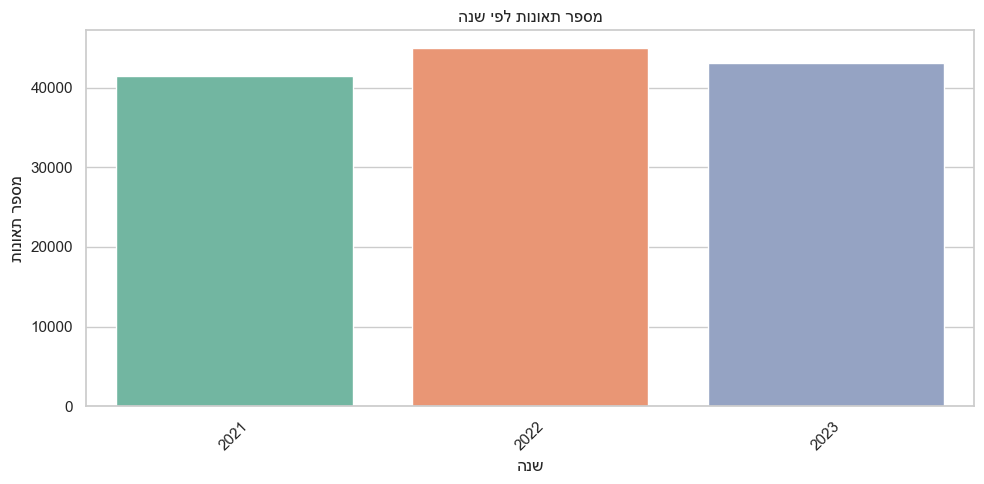

In [203]:
plt.figure(figsize=(10, 5))
sns.countplot(data=accdata, x=reshape_hebrew('SHNAT_TEUNA_x'), palette='Set2',legend=False,hue='SHNAT_TEUNA_x')
plt.title(reshape_hebrew("מספר תאונות לפי שנה"))
plt.xlabel(reshape_hebrew("שנה"))
plt.ylabel(reshape_hebrew("מספר תאונות"))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

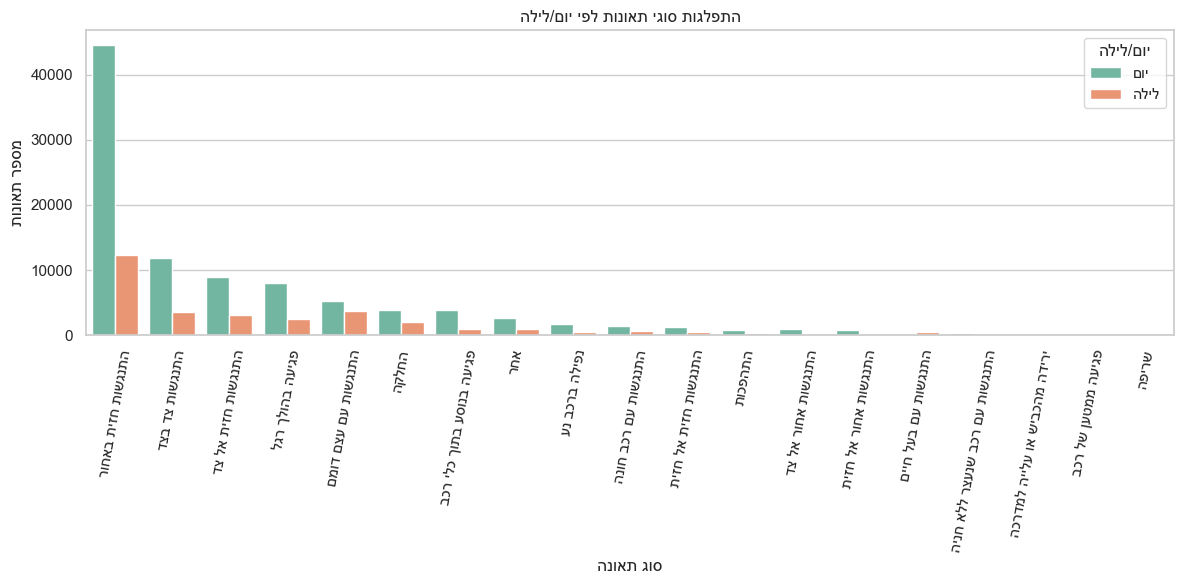

In [205]:

# עיצוב גרפים
sns.set(style="whitegrid", font="Arial")
plt.rcParams['axes.unicode_minus'] = False

# עיבוד טקסטים לצירים וכותרות
xlabel = reshape_hebrew("סוג תאונה")
ylabel = reshape_hebrew("מספר תאונות")
title = reshape_hebrew("התפלגות סוגי תאונות לפי יום/לילה")
legend_title = reshape_hebrew("יום/לילה")

# מיפוי טקסטים בעברית לעמודות
accdata = accdata[accdata['SUG_TEUNA'].notna() & accdata['YOM_LAYLA'].notna()].copy()

# מיפוי עברית יעיל לעמודת SUG_TEUNA
sug_teuna_map = {val: reshape_hebrew(val) for val in accdata['SUG_TEUNA'].unique()}
accdata['SUG_TEUNA_HE'] = accdata['SUG_TEUNA'].map(sug_teuna_map)

# מיפוי עברית לעמודת YOM_LAYLA
yom_layla_map = {val: reshape_hebrew(val) for val in accdata['YOM_LAYLA'].unique()}
accdata['YOM_LAYLA_HE'] = accdata['YOM_LAYLA'].map(yom_layla_map)

# ציור הגרף
plt.figure(figsize=(12, 6))
sns.countplot(data=accdata, x='SUG_TEUNA_HE', hue='YOM_LAYLA_HE', palette='Set2', order=accdata['SUG_TEUNA_HE'].value_counts().index)
 
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title(title)
plt.legend(title=legend_title)
plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

In [207]:
def detailed_day_night_comparison1(accdata):
    """
    השוואה מפורטת בין תאונות יום ולילה
    """
    # בדיקת התפלגות בסיסית
    day_night_counts = accdata['YOM_LAYLA'].value_counts()
    day_night_pct = accdata['YOM_LAYLA'].value_counts(normalize=True) * 100

    for condition in day_night_counts.index:
        condition_fixed = (condition)
        count = day_night_counts[condition]
        pct = day_night_pct[condition]

    # גרפים השוואתיים
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # גרף 1: התפלגות בסיסית
    day_night_pct_reshaped = day_night_pct.rename(index=reshape_hebrew)
    day_night_pct_reshaped.plot(kind='pie', ax=axes[0, 0], autopct='%1.1f%%',
                                colors=['gold', 'navy'] if len(day_night_pct) == 2 else None)
    axes[0, 0].set_title(reshape_hebrew('התפלגות כללית: יום מול לילה'))
    axes[0, 0].set_ylabel('')

    # גרף 2: התפלגות לפי שעות
    hourly_breakdown = accdata.groupby(['SHAA_CLEAN', 'YOM_LAYLA']).size().unstack(fill_value=0)
    hourly_breakdown.columns = [reshape_hebrew(col) for col in hourly_breakdown.columns]
    hourly_breakdown.plot(kind='bar', ax=axes[0, 1],
                          color=['gold', 'navy'] if hourly_breakdown.shape[1] == 2 else None)
    axes[0, 1].set_title(reshape_hebrew('התפלגות לפי שעות'))
    axes[0, 1].set_xlabel(reshape_hebrew('שעה'))
    axes[0, 1].tick_params(axis='x', rotation=45)

    # גרף 3: ימי השבוע
    weekly_breakdown = accdata.groupby(['YOM_BASHAVUA', 'YOM_LAYLA']).size().unstack(fill_value=0)
    weekly_breakdown.index = [(i) for i in weekly_breakdown.index]
    weekly_breakdown.columns = [reshape_hebrew(col) for col in weekly_breakdown.columns]
    weekly_breakdown.plot(kind='bar', ax=axes[1, 0],
                          color=['gold', 'navy'] if weekly_breakdown.shape[1] == 2 else None)
    axes[1, 0].set_title(reshape_hebrew('התפלגות לפי ימי השבוע'))
    axes[1, 0].tick_params(axis='x', rotation=45)


    # גרף 4: סוגי תאונות
    accident_types_breakdown = accdata.groupby(['SUG_TEUNA', 'YOM_LAYLA']).size().unstack(fill_value=0)
    top_accidents = accident_types_breakdown.sum(axis=1).nlargest(8).index
    sub_df = accident_types_breakdown.loc[top_accidents]
    sub_df.index = [reshape_hebrew(i) for i in sub_df.index]
    sub_df.columns = [reshape_hebrew(col) for col in sub_df.columns]
    sub_df.plot(kind='bar', ax=axes[1, 1],
                color=['gold', 'navy'] if sub_df.shape[1] == 2 else None)
    axes[1, 1].set_title(reshape_hebrew('סוגי תאונות מובילים'))
    axes[1, 1].tick_params(axis='x', rotation=45)


def balanced_day_night_analysis(accdata):
    """
    ניתוח מאוזן ומלא של יום ולילה
    """
    print("☀️🌙 ניתוח מאוזן: יום ולילה")
    print("=" * 40)
    
    # חלוקה לשני דטא-סטים
    day_data = accdata[accdata['YOM_LAYLA'] == 'יום'].copy()
    night_data = accdata[accdata['YOM_LAYLA'] == 'לילה'].copy()
    
    print(f"📊 נתונים בסיסיים:")
    print(f"תאונות יום: {len(day_data):,} (75.0%)")
    print(f"תאונות לילה: {len(night_data):,} (25.0%)")
    print(f"יחס יום/לילה: {len(day_data)/len(night_data):.1f}:1")
    
    return day_data, night_data

def analyze_day_specific_patterns(day_data):
    """
    ניתוח דפוסים ייחודיים לתאונות יום
    """
    print("\n☀️ דפוסים ייחודיים לתאונות יום")
    print("=" * 45)
    
    # 1. שעות העומס ביום
    day_hourly = day_data.groupby('SHAA_CLEAN').agg({
        'pk_teuna_fikt': 'count',
        'SUG_TEUNA': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'מעורב',
        'SUG_REHEV_LMS': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'מעורב'
    })
    day_hourly.columns = ['תאונות', 'סוג_תאונה_נפוץ', 'רכב_נפוץ']
    day_hourly = day_hourly.sort_values('תאונות', ascending=False)
    
    print("🕐 השעות המסוכנות ביותר ביום:")
    print(day_hourly.head(10))
    
    # זיהוי שעות עומס ושעות רגילות
    rush_hours = [7, 8, 16, 17, 18]
    rush_accidents = day_data[day_data['SHAA_CLEAN'].isin(rush_hours)]
    non_rush_accidents = day_data[~day_data['SHAA_CLEAN'].isin(rush_hours)]
    
    print(f"\n🚦 תאונות בשעות עומס: {len(rush_accidents):,} ({len(rush_accidents)/len(day_data)*100:.1f}%)")
    print(f"⏰ תאונות בשעות רגילות: {len(non_rush_accidents):,} ({len(non_rush_accidents)/len(day_data)*100:.1f}%)")
    
    # ניתוח סוגי תאונות בשעות עומס
    rush_accident_types = rush_accidents['SUG_TEUNA'].value_counts().head(8)
    print(f"\n🚗 סוגי תאונות נפוצים בשעות עומס:")
    for i, (accident_type, count) in enumerate(rush_accident_types.items(), 1):
        pct = (count / len(rush_accidents)) * 100
        print(f"{i:2}. {accident_type}: {count:,} ({pct:.1f}%)")
    
    # ניתוח רכבים מעורבים ביום
    day_vehicles = day_data['SUG_REHEV_LMS'].value_counts().head(10)
    print(f"\n🚙 רכבים מעורבים ביותר בתאונות יום:")
    for i, (vehicle, count) in enumerate(day_vehicles.items(), 1):
        pct = (count / len(day_data)) * 100
        print(f"{i:2}. {vehicle}: {count:,} ({pct:.1f}%)")
    
    return day_hourly, rush_accidents, non_rush_accidents

def analyze_night_specific_patterns(night_data):
    """
    ניתוח דפוסים ייחודיים לתאונות לילה
    """
    print("\n🌙 דפוסים ייחודיים לתאונות לילה")
    print("=" * 50)
    
    # שעות לילה מסוכנות
    night_hourly = night_data.groupby('SHAA_CLEAN').agg({
        'pk_teuna_fikt': 'count',
        'SUG_TEUNA': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'מעורב',
        'SUG_REHEV_LMS': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'מעורב'
    })
    night_hourly.columns = ['תאונות', 'סוג_תאונה_נפוץ', 'רכב_נפוץ']
    night_hourly = night_hourly.sort_values('תאונות', ascending=False)
    
    print("🕐 השעות המסוכנות ביותר בלילה:")
    print(night_hourly.head(10))
    
    # זיהוי שעות מתות (02:00-05:00)
    dead_hours = [2, 3, 4, 5]
    dead_hour_accidents = night_data[night_data['SHAA_CLEAN'].isin(dead_hours)]
    
    print(f"\n💀 תאונות ב'שעות המתות' (02:00-05:00): {len(dead_hour_accidents):,}")
    print(f"    זה {len(dead_hour_accidents)/len(night_data)*100:.1f}% מתאונות הלילה")
    
    # ניתוח סוגי תאונות בלילה
    night_accident_types = night_data['SUG_TEUNA'].value_counts().head(8)
    print(f"\n🌑 סוגי תאונות נפוצים בלילה:")
    for i, (accident_type, count) in enumerate(night_accident_types.items(), 1):
        pct = (count / len(night_data)) * 100
        print(f"{i:2}. {accident_type}: {count:,} ({pct:.1f}%)")
    
    # ניתוח רכבים מעורבים בלילה
    night_vehicles = night_data['SUG_REHEV_LMS'].value_counts().head(10)
    print(f"\n🏍️ רכבים מעורבים ביותר בתאונות לילה:")
    for i, (vehicle, count) in enumerate(night_vehicles.items(), 1):
        pct = (count / len(night_data)) * 100
        print(f"{i:2}. {vehicle}: {count:,} ({pct:.1f}%)")
    
    return night_hourly, dead_hour_accidents

def compare_day_vs_night_patterns(day_data, night_data):
    """
    השוואה ישירה בין דפוסי יום ולילה
    """
    print("\n⚖️ השוואה ישירה: יום מול לילה")
    print("=" * 45)
    
    # 1. השוואת סוגי תאונות
    day_accidents = day_data['SUG_TEUNA'].value_counts(normalize=True) * 100
    night_accidents = night_data['SUG_TEUNA'].value_counts(normalize=True) * 100
    
    accident_comparison = pd.DataFrame({
        'יום_אחוז': day_accidents,
        'לילה_אחוז': night_accidents
    }).fillna(0)
    
    accident_comparison['הפרש_לילה_מינוס_יום'] = accident_comparison['לילה_אחוז'] - accident_comparison['יום_אחוז']
    accident_comparison = accident_comparison.sort_values('הפרש_לילה_מינוס_יום', ascending=False)
    
    print("🔍 סוגי תאונות שנפוצים יותר בלילה מאשר ביום:")
    night_dominant = accident_comparison[accident_comparison['הפרש_לילה_מינוס_יום'] > 1].head(5)
    for accident_type, row in night_dominant.iterrows():
        print(f"  • {accident_type}:")
        print(f"    לילה: {row['לילה_אחוז']:.1f}% | יום: {row['יום_אחוז']:.1f}% | הפרש: +{row['הפרש_לילה_מינוס_יום']:.1f}%")
    
    print("\n🔍 סוגי תאונות שנפוצים יותר ביום מאשר בלילה:")
    day_dominant = accident_comparison[accident_comparison['הפרש_לילה_מינוס_יום'] < -1].tail(5)
    for accident_type, row in day_dominant.iterrows():
        print(f"  • {accident_type}:")
        print(f"    יום: {row['יום_אחוז']:.1f}% | לילה: {row['לילה_אחוז']:.1f}% | הפרש: {row['הפרש_לילה_מינוס_יום']:.1f}%")
    
    # 2. השוואת רכבים
    day_vehicles = day_data['SUG_REHEV_LMS'].value_counts(normalize=True) * 100
    night_vehicles = night_data['SUG_REHEV_LMS'].value_counts(normalize=True) * 100
    
    vehicle_comparison = pd.DataFrame({
        'יום_אחוז': day_vehicles,
        'לילה_אחוז': night_vehicles
    }).fillna(0)
    
    vehicle_comparison['הפרש_לילה_מינוס_יום'] = vehicle_comparison['לילה_אחוז'] - vehicle_comparison['יום_אחוז']
    vehicle_comparison = vehicle_comparison.sort_values('הפרש_לילה_מינוס_יום', ascending=False)
    
    print("\n🏍️ רכבים שמעורבים יותר בלילה:")
    night_vehicles_dominant = vehicle_comparison[vehicle_comparison['הפרש_לילה_מינוס_יום'] > 0.5].head(5)
    for vehicle, row in night_vehicles_dominant.iterrows():
        print(f"  • {vehicle}:")
        print(f"    לילה: {row['לילה_אחוז']:.1f}% | יום: {row['יום_אחוז']:.1f}% | הפרש: +{row['הפרש_לילה_מינוס_יום']:.1f}%")
    
    print("\n🚗 רכבים שמעורבים יותר ביום:")
    day_vehicles_dominant = vehicle_comparison[vehicle_comparison['הפרש_לילה_מינוס_יום'] < -0.5].tail(5)
    for vehicle, row in day_vehicles_dominant.iterrows():
        print(f"  • {vehicle}:")
        print(f"    יום: {row['יום_אחוז']:.1f}% | לילה: {row['לילה_אחוז']:.1f}% | הפרש: {row['הפרש_לילה_מינוס_יום']:.1f}%")
    
    # 3. השוואת יחידות משטרה
    day_units = day_data['YEHIDA'].value_counts()
    night_units = night_data['YEHIDA'].value_counts()
    
    units_comparison = pd.DataFrame({
        'יום': day_units,
        'לילה': night_units
    }).fillna(0)
    
    units_comparison['סך_הכל'] = units_comparison.sum(axis=1)
    units_comparison['אחוז_לילה'] = (units_comparison['לילה'] / units_comparison['סך_הכל'] * 100).round(1)
    units_comparison = units_comparison.sort_values('אחוז_לילה', ascending=False)
    
    print(f"\n👮 יחידות משטרה עם אחוז תאונות לילה גבוה:")
    for unit, row in units_comparison.head(5).iterrows():
        print(f"  • {unit}: {row['אחוז_לילה']:.1f}% לילה ({row['לילה']:.0f} מתוך {row['סך_הכל']:.0f})")
    
    print(f"\n👮 יחידות משטרה עם אחוז תאונות יום גבוה:")
    for unit, row in units_comparison.tail(5).iterrows():
        day_pct = 100 - row['אחוז_לילה']
        print(f"  • {unit}: {day_pct:.1f}% יום ({row['יום']:.0f} מתוך {row['סך_הכל']:.0f})")
    
    return accident_comparison, vehicle_comparison, units_comparison

def create_comprehensive_visualizations(day_data, night_data):
    """
    יצירת גרפים מקיפים להשוואת יום ולילה
    """
    print("\n📊 יוצר גרפים השוואתיים מקיפים...")
    
    fig, axes = plt.subplots(3, 2, figsize=(20, 18))
    
    # גרף 1: התפלגות שעות - יום
    day_hourly = day_data.groupby('SHAA_CLEAN').size()
    day_hourly.plot(kind='bar', ax=axes[0,0], color='gold', alpha=0.8)
    axes[0,0].set_title(reshape_hebrew('תאונות יום לפי שעה'), fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel(reshape_hebrew('שעה'))
    axes[0,0].set_ylabel(reshape_hebrew('מספר תאונות'))
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # גרף 2: התפלגות שעות - לילה
    night_hourly = night_data.groupby('SHAA_CLEAN').size()
    night_hourly.plot(kind='bar', ax=axes[0,1], color='navy', alpha=0.8)
    axes[0,1].set_title(reshape_hebrew('תאונות לילה לפי שעה'), fontsize=14, fontweight='bold')
    axes[0,1].set_xlabel(reshape_hebrew('שעה'))
    axes[0,1].set_ylabel(reshape_hebrew('מספר תאונות'))
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # גרף 3: סוגי תאונות מובילים - יום
    day_accidents = day_data['SUG_TEUNA'].value_counts().head(8)
    day_accidents.index = day_accidents.index.map(reshape_hebrew)  # ← עיבוד עברית
    day_accidents.plot(kind='barh', ax=axes[1,0], color='orange', alpha=0.8)
    axes[1,0].set_title(reshape_hebrew('סוגי תאונות מובילים - יום'), fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel(reshape_hebrew('מספר תאונות'))
    
    # גרף 4: סוגי תאונות מובילים - לילה
    night_accidents = night_data['SUG_TEUNA'].value_counts().head(8)
    night_accidents.index = night_accidents.index.map(reshape_hebrew)  # ← עיבוד עברית
    night_accidents.plot(kind='barh', ax=axes[1,1], color='purple', alpha=0.8)
    axes[1,1].set_title(reshape_hebrew('סוגי תאונות מובילים - לילה'), fontsize=14, fontweight='bold')
    axes[1,1].set_xlabel(reshape_hebrew('מספר תאונות')) 
    
    # גרף 5: רכבים מעורבים - יום
    day_vehicles = day_data['SUG_REHEV_LMS'].value_counts().head(8)
    day_vehicles.index = day_vehicles.index.map(reshape_hebrew)
    day_vehicles.plot(kind='pie', ax=axes[2,0], autopct='%1.1f%%')
    axes[2,0].set_title(reshape_hebrew('רכבים מעורבים - יום'), fontsize=14, fontweight='bold')
    axes[2,0].set_ylabel('')

    
    # גרף 6: רכבים מעורבים - לילה
    night_vehicles = night_data['SUG_REHEV_LMS'].value_counts().head(8)
    night_vehicles.index = night_vehicles.index.map(reshape_hebrew)
    night_vehicles.plot(kind='pie', ax=axes[2,1], autopct='%1.1f%%')
    axes[2,1].set_title(reshape_hebrew('רכבים מעורבים - לילה'), fontsize=14, fontweight='bold')
    axes[2,1].set_ylabel('')
    
    plt.tight_layout()
    plt.show()
    detailed_day_night_comparison1(accdata)

def day_specific_insights(day_data, night_data):
    """
    תובנות ספציפיות לתאונות יום
    """
    print("\n☀️ תובנות ספציפיות לתאונות יום")
    print("=" * 45)
    
    # תאונות עומס vs רגילות
    rush_hours = [7, 8, 16, 17, 18]
    rush_day = day_data[day_data['SHAA_CLEAN'].isin(rush_hours)]
    normal_day = day_data[~day_data['SHAA_CLEAN'].isin(rush_hours)]
    
    print(f"📈 ניתוח שעות עומס ביום:")
    print(f"  • שעות עומס (7-8, 16-18): {len(rush_day):,} תאונות")
    print(f"  • שעות רגילות: {len(normal_day):,} תאונות")
    print(f"  • יחס עומס/רגיל: {len(rush_day)/len(normal_day):.2f}")
    
    # השוואת צפיפות תאונות
    rush_hours_count = len(rush_hours)
    normal_hours_count = 24 - rush_hours_count - len([h for h in range(24) if h >= 22 or h <= 6])  # לא כולל לילה
    
    rush_density = len(rush_day) / rush_hours_count
    normal_density = len(normal_day) / normal_hours_count if normal_hours_count > 0 else 0
    
    print(f"  • צפיפות תאונות בשעת עומס: {rush_density:.0f} תאונות/שעה")
    print(f"  • צפיפות תאונות בשעה רגילה: {normal_density:.0f} תאונות/שעה")
    print(f"  • גורם כפל סיכון בעומס: x{rush_density/normal_density:.1f}")
    
    # מה מיוחד בתאונות יום מול לילה?
    print(f"\n🔍 מה מייחד תאונות יום:")
    
    # יחס התנגשויות אחור (טיפוסי לעומס)
    day_rear_end = (day_data['SUG_TEUNA'].str.contains('חזית באחור', na=False)).sum()
    night_rear_end = (night_data['SUG_TEUNA'].str.contains('חזית באחור', na=False)).sum()
    
    day_rear_pct = day_rear_end / len(day_data) * 100
    night_rear_pct = night_rear_end / len(night_data) * 100
    
    print(f"  • פגיעות אחור ביום: {day_rear_pct:.1f}% מהתאונות")
    print(f"  • פגיעות אחור בלילה: {night_rear_pct:.1f}% מהתאונות")
    print(f"  • יום הוא x{day_rear_pct/night_rear_pct:.1f} יותר מועד לפגיעות אחור")
    
    # רכבים מסחריים ביום
    commercial_vehicles = ['אוטובוס', 'משא', 'מונית', 'טרנזיט']
    day_commercial = day_data[day_data['SUG_REHEV_LMS'].str.contains('|'.join(commercial_vehicles), na=False)]
    night_commercial = night_data[night_data['SUG_REHEV_LMS'].str.contains('|'.join(commercial_vehicles), na=False)]
    
    day_commercial_pct = len(day_commercial) / len(day_data) * 100
    night_commercial_pct = len(night_commercial) / len(night_data) * 100
    
    print(f"  • רכבים מסחריים ביום: {day_commercial_pct:.1f}% מהתאונות")
    print(f"  • רכבים מסחריים בלילה: {night_commercial_pct:.1f}% מהתאונות")
    print(f"  • יום הוא x{day_commercial_pct/night_commercial_pct:.1f} יותר מועד לתאונות מסחריות")

def run_complete_balanced_analysis(accdata):
    """
    הרצת ניתוח מאוזן מלא של יום ולילה
    """
    print("🚀 מתחיל ניתוח מאוזן מלא: יום ולילה")
    print("=" * 55)
    
    # 1. חלוקה בסיסית
    day_data, night_data = balanced_day_night_analysis(accdata)
    
    # 2. ניתוח דפוסים ייחודיים ליום
    day_patterns = analyze_day_specific_patterns(day_data)
    
    # 3. ניתוח דפוסים ייחודיים ללילה
    night_patterns = analyze_night_specific_patterns(night_data)
    
    # 4. השוואה ישירה
    comparisons = compare_day_vs_night_patterns(day_data, night_data)
    
    # 5. תובנות ספציפיות ליום
    day_specific_insights(day_data, night_data)
    
    # 6. יצירת גרפים
    create_comprehensive_visualizations(day_data, night_data)
    

🚀 מתחיל ניתוח מאוזן מלא: יום ולילה
☀️🌙 ניתוח מאוזן: יום ולילה
📊 נתונים בסיסיים:
תאונות יום: 97,028 (75.0%)
תאונות לילה: 32,426 (25.0%)
יחס יום/לילה: 3.0:1

☀️ דפוסים ייחודיים לתאונות יום
🕐 השעות המסוכנות ביותר ביום:
            תאונות      סוג_תאונה_נפוץ         רכב_נפוץ
SHAA_CLEAN                                             
15           10261  התנגשות חזית באחור  רכב נוסעים פרטי
16           10200  התנגשות חזית באחור  רכב נוסעים פרטי
14            9459  התנגשות חזית באחור  רכב נוסעים פרטי
13            8940  התנגשות חזית באחור  רכב נוסעים פרטי
12            8526  התנגשות חזית באחור  רכב נוסעים פרטי
8             8465  התנגשות חזית באחור  רכב נוסעים פרטי
7             7441  התנגשות חזית באחור  רכב נוסעים פרטי
11            7210  התנגשות חזית באחור  רכב נוסעים פרטי
10            6637  התנגשות חזית באחור  רכב נוסעים פרטי
17            6527  התנגשות חזית באחור  רכב נוסעים פרטי

🚦 תאונות בשעות עומס: 36,653 (37.8%)
⏰ תאונות בשעות רגילות: 60,375 (62.2%)

🚗 סוגי תאונות נפוצים בשעות עומס:
 1.

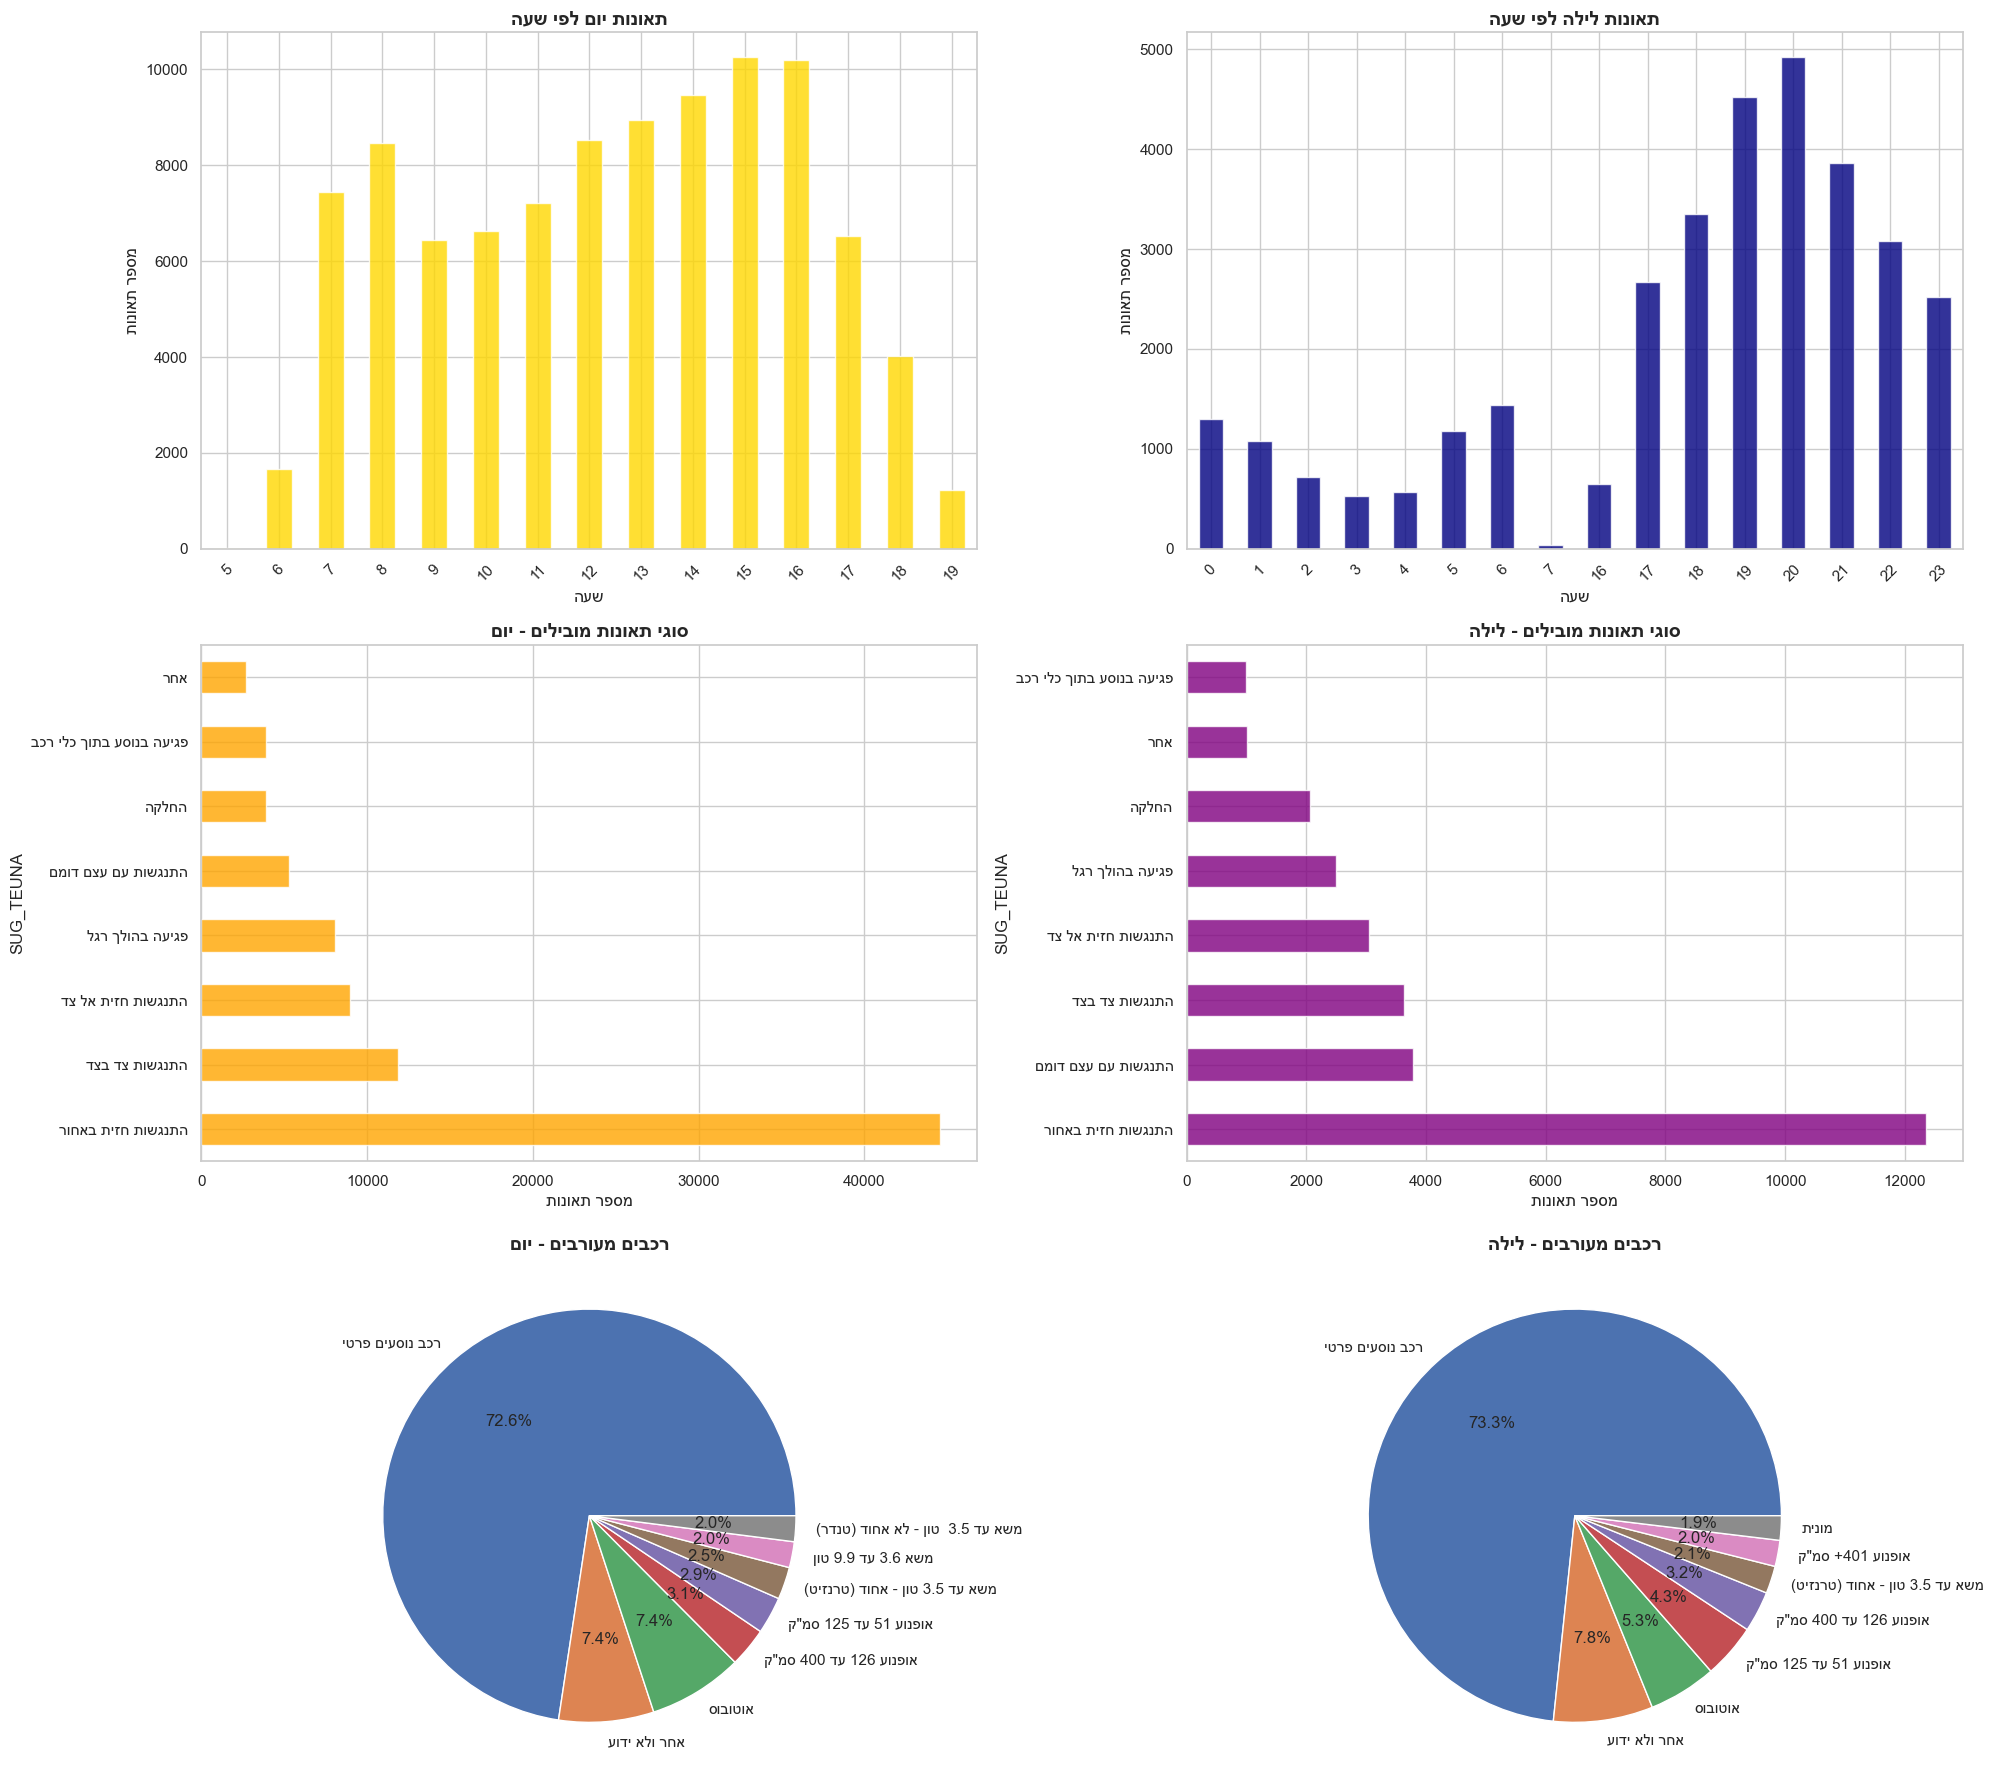

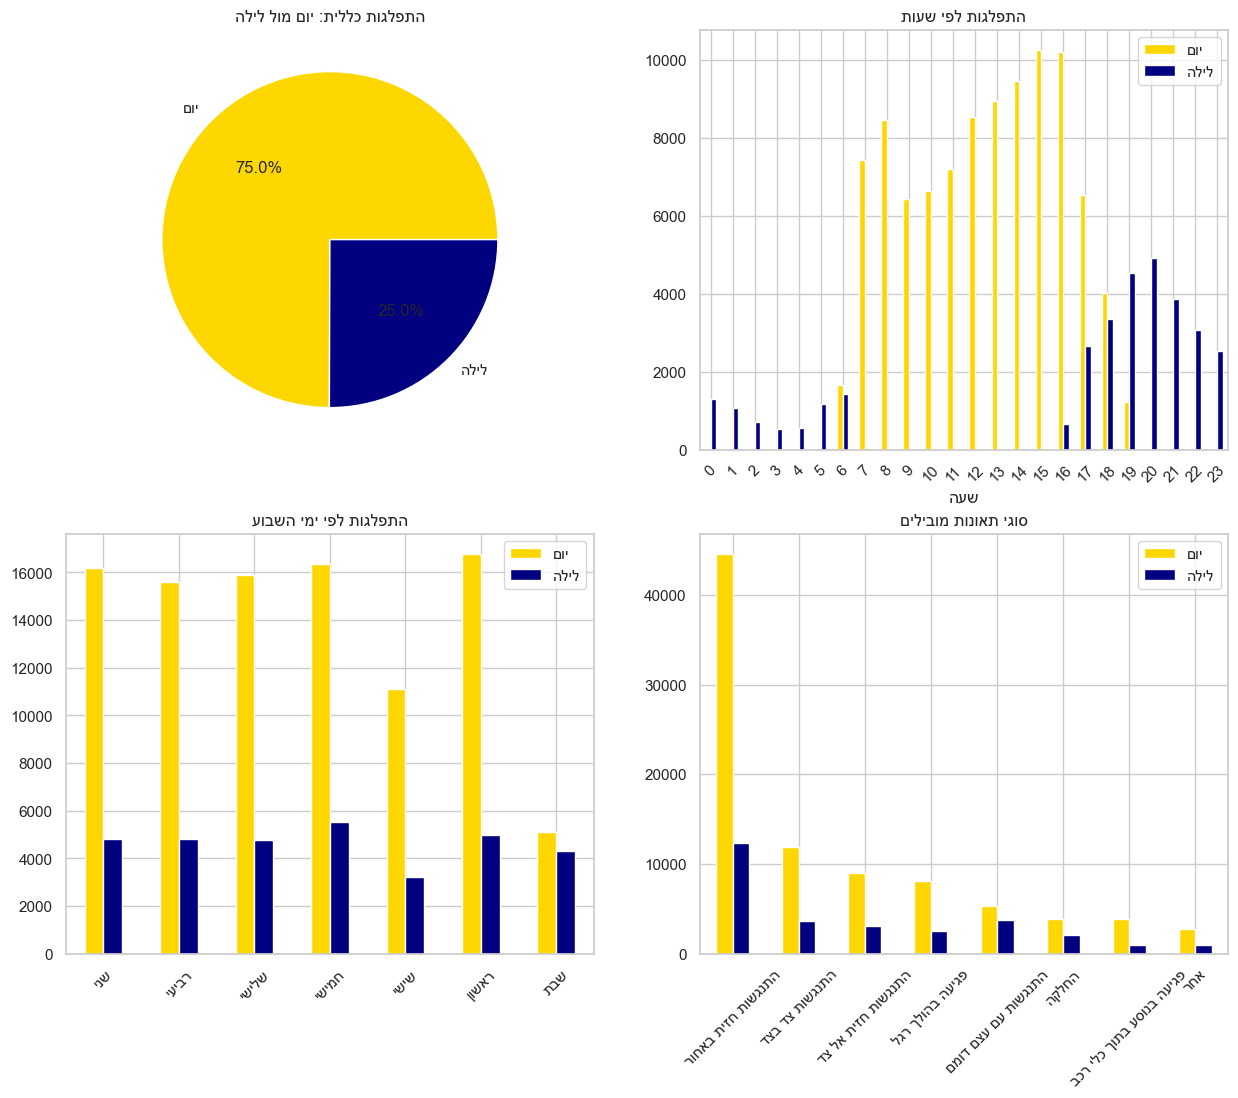

In [209]:
run_complete_balanced_analysis(accdata)

# 📊 ניתוח תאונות דרכים – השוואה בין יום ללילה

ניתוח גרפי מקיף של תאונות דרכים בישראל לפי: זמן (יום/לילה), שעות, ימי השבוע וסוג התאונה. הנתונים חושפים תובנות משמעותיות באשר להתנהגות בכבישים.

---

## 🔆 1. התפלגות כללית: יום מול לילה

- **75% מהתאונות מתרחשות ביום**
- **25% מהתאונות מתרחשות בלילה**

✅ **מסקנה**: 
העומס התחבורתי הגבוה בשעות היום, כולל עבודה, לימודים ותנועה עירונית, תורם לכמות תאונות גבוהה יותר לעומת שעות הלילה.

---

## 🕒 2. התפלגות לפי שעות

| טווח שעות       | תובנות עיקריות |
|------------------|------------------|
| 07:00–17:00       | שיא התאונות ביום. תואם לשעות פעילות רגילות. |
| 17:00–23:00       | עליה בתאונות בלילה – ירידה בערנות, צפיפות בשעות החזרה מהעבודה. |
| 00:00–06:00       | מעט תאונות בפני מיעוט כל הרכב על הכביש . |

✅ **מסקנות**:
- שעות היום רוויות בתנועה ולכן יש יותר תאונות.
- שעות המעבר בין יום ללילה (16:00–19:00) הן **זמן סיכון גבוה**.
  

---

## 📅 3. התפלגות לפי ימי השבוע

| יום בשבוע | תובנות |
|-----------|---------|
| ראשון עד חמישי | נפח התאונות הגבוה ביותר – תואם לימי עבודה ולחץ תחבורתי |
| שישי | ירידה משמעותית בתאונות, גם ביום וגם בלילה |
| שבת | היום עם הכי מעט תאונות – כנראה עקב תנועה מופחתת |

✅ **מסקנות**:
- **שיא התאונות** מתרחש באמצע השבוע, בשעות הנסיעה לעבודה והחזרה לבית.
- שישי־שבת רגועים יותר – פחות תנועה, פחות עומס, ולכן פחות תאונות.

---

## 🚘 4. סוגי תאונות עיקריים – יום מול לילה

| סוג תאונה                          | בולטות ביום | בולטות בלילה | תובנות |
|-----------------------------------|-------------|--------------|--------|
| פגיעה בהולך רגל במעבר חציה       | גבוהה מאוד  | נמוכה יחסית  | נפוצה ביום עקב פעילות עירונית רגלית |
| התנגשויות צד לצד / חזית-אחור     | גבוהה        | קיימת         | קלאסית לעומסי תנועה |
| התנגשויות חזית-צד / עם עצם דומם | קיימת        | בולטת בלילה  | לרוב בלילה – פחות רכבים, חשכה |

✅ **מסקנות**:
- ביום – תאונות קלאסיות של עומס ופעילות עירונית.
- בלילה – יותר תאונות מסוג התנגשות עם עצם דומם וחזית מאחורה.

---

## 🧠 מסקנות כוללות

- שעות השיא ביום (בוקר ואחר צהריים) הן זמני סיכון גבוה.
- יש **שוני באופי התאונות** בין יום ללילה – ביום יותר מעורבות הולכי רגל .

---

## 🚦 המלצות ולקחים

1. 🔅 **הגברת מודעות ביום** – במיוחד בשעות הבוקר ואחה"צ.
2. 🌙 **נהיגה זהירה בלילה** – התאמות תאורה, הימנעות מנהיגה בעייפות.
3. 👮 **אכיפה ממוקדת לפי שעות וסוגי תאונה** – למשל, יותר נוכחות משטרתית בצמתים בשעות שיא.
4. 🚸 **הגנה על הולכי רגל ביום** – בפרט באזורים עירוניים ובמעברי חציה.
5. 📆 **פעולות הסברה בימי ראשון–חמישי** – ריכוז מאמצי מניעה בשיאי התאונות.

---


# פילוח הנתונים לפי שעת התאונה 

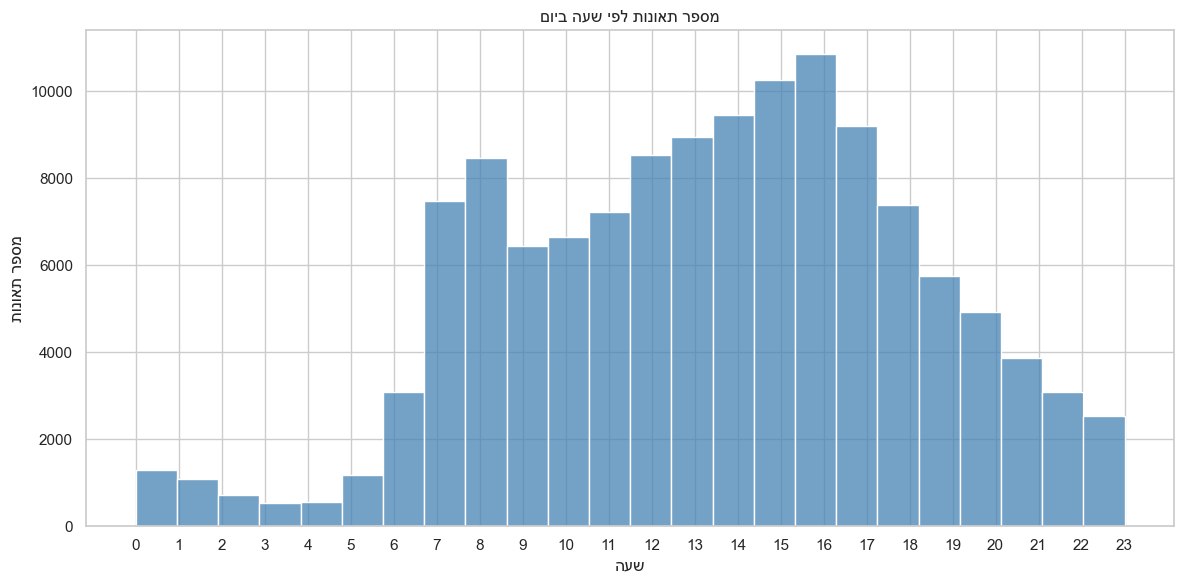

In [87]:
# התפלגות תאונות לפי שעות (אם העמודה 'SHAA' מספרית)
accdata['SHAA_CLEAN'] = pd.to_numeric(accdata['SHAA_CLEAN'], errors='coerce')
plt.figure(figsize=(12, 6))
sns.histplot(accdata['SHAA_CLEAN'].dropna(), bins=24, kde=False, color='steelblue')
plt.title(reshape_hebrew("מספר תאונות לפי שעה ביום"))
plt.xlabel(reshape_hebrew("שעה"))
plt.ylabel(reshape_hebrew("מספר תאונות"))
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

# התפלגות שעות לפי סוג תאונה

# 🔍 ניתוח דפוסי שעות לפי סוג תאונה

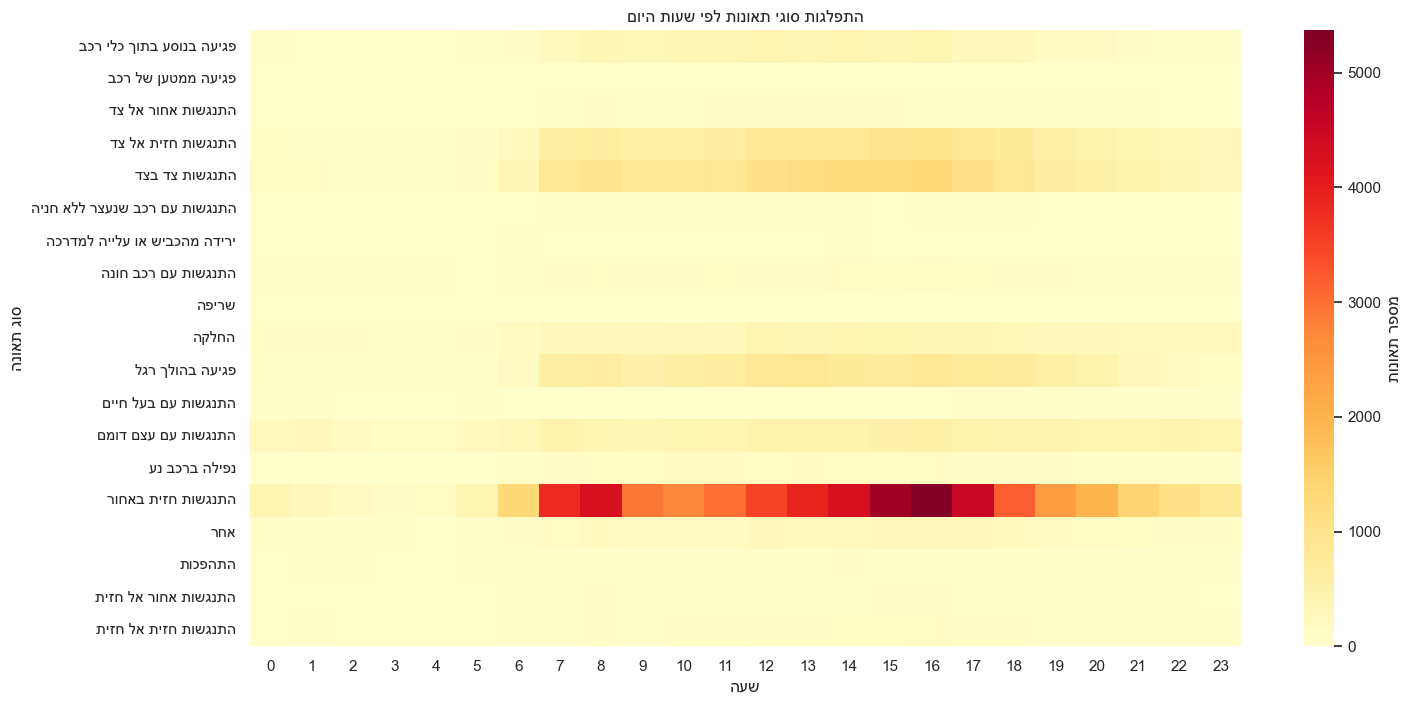

In [89]:

accdata['SUG_TEUNA_HE'] = accdata['SUG_TEUNA'].map(hebrew_map)

pivot_hour_accident = accdata.pivot_table(
    index='SHAA_CLEAN', 
    columns='SUG_TEUNA_HE', 
    values='pk_teuna_fikt', 
    aggfunc='count', 
    fill_value=0
)

plt.figure(figsize=(16, 8))
sns.heatmap(pivot_hour_accident.T, cmap='YlOrRd', cbar_kws={'label':reshape_hebrew('מספר תאונות')})
plt.title(reshape_hebrew('התפלגות סוגי תאונות לפי שעות היום'))
plt.xlabel(reshape_hebrew('שעה'))
plt.ylabel(reshape_hebrew('סוג תאונה'))
plt.show()

# 🔹 מסקנה

בבדיקה זו נבחן את כמות התאונות לאורך השנים 2021–2023, ונשווה בין סוגי התאונות **בשעות היום** לעומת **שעות הלילה**.  
המטרה היא להבין האם קיימת מגמה של עלייה/ירידה בתאונות לאורך זמן, והאם תנאי התאורה (יום/לילה) משפיעים על רמת הסיכון בכבישים.

#### ✅ תובנות מהנתונים:
- ניכרת **שכיחות גבוהה יותר של תאונות בשעות היום** לעומת שעות הלילה.

#### 📌 השלכות:
- ריבוי תאונות ביום עשוי לנבוע מהיקף נסיעות גבוה יותר, ריבוי הולכי רגל, ועומסים בשעות השיא – ולכן יש מקום להשקיע בפתרונות **ניהול עומסים** ו**שיפור תשתיות** באור יום.
- יש להמשיך לעקוב אחרי הנתונים בשנים הבאות כדי להבין האם מדובר במגמה ארוכת טווח או בחריג נקודתי.



# 🔹  באילו חודשים יש ריכוז גבוה של תאונות?  


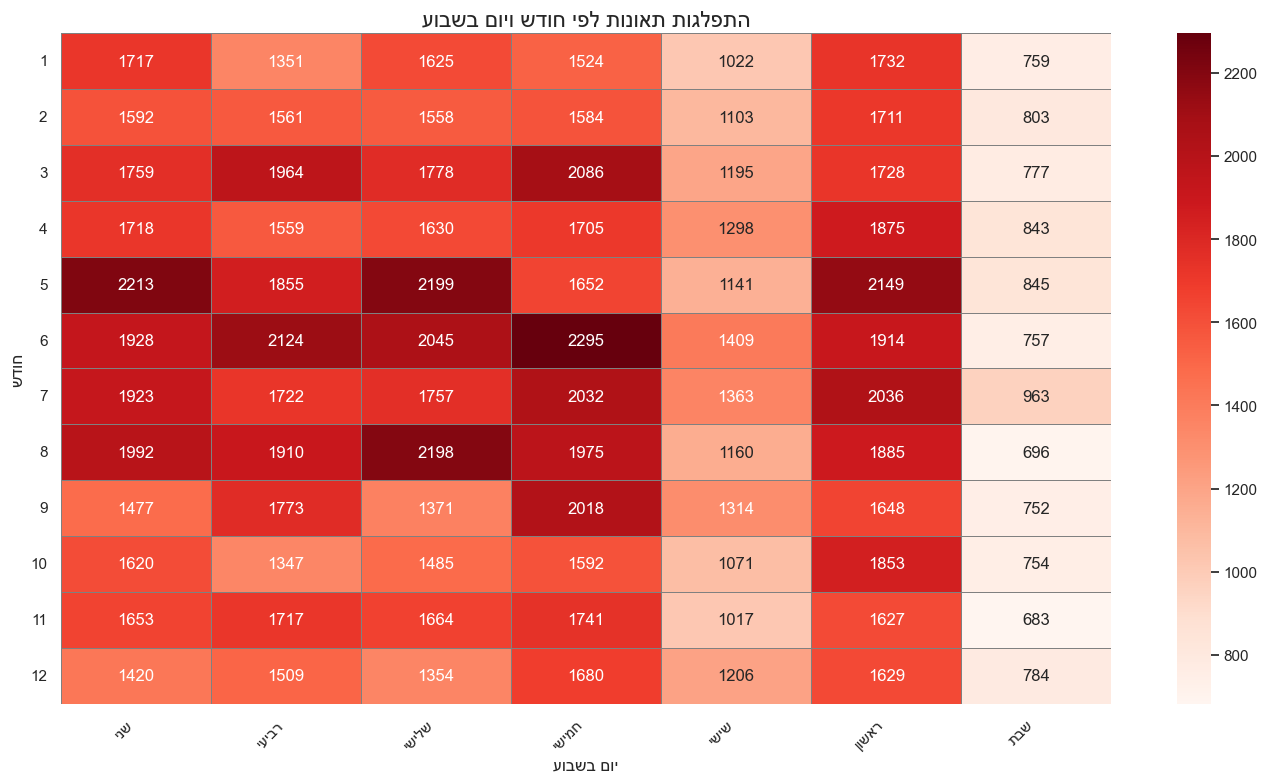

In [92]:


# יצירת טבלת heatmap לפי חודש ויום בשבוע
heatmap_data = accdata.groupby(['HODESH_TEUNA_y', 'YOM_BASHAVUA']).size().unstack(fill_value=0)

# תיקון עברית באינדקסים
heatmap_data.index = [reshape_hebrew(idx) for idx in heatmap_data.index]
heatmap_data.columns = [reshape_hebrew(col) for col in heatmap_data.columns]

# ציור ה־heatmap
plt.figure(figsize=(14, 8))
ax = sns.heatmap(heatmap_data, cmap='Reds', annot=True, fmt='d', linewidths=0.5, linecolor='gray')

# עיבוד מחדש של תוויות הצירים אחרי הציור
ax.set_xticklabels([reshape_hebrew(label.get_text()) for label in ax.get_xticklabels()], rotation=45, ha='right')
ax.set_yticklabels([reshape_hebrew(label.get_text()) for label in ax.get_yticklabels()], rotation=0)

# כותרות
plt.title(reshape_hebrew("התפלגות תאונות לפי חודש ויום בשבוע"), fontsize=16)
plt.xlabel(reshape_hebrew("יום בשבוע"))
plt.ylabel(reshape_hebrew("חודש"))

# פריסה יפה
plt.tight_layout()
plt.show()

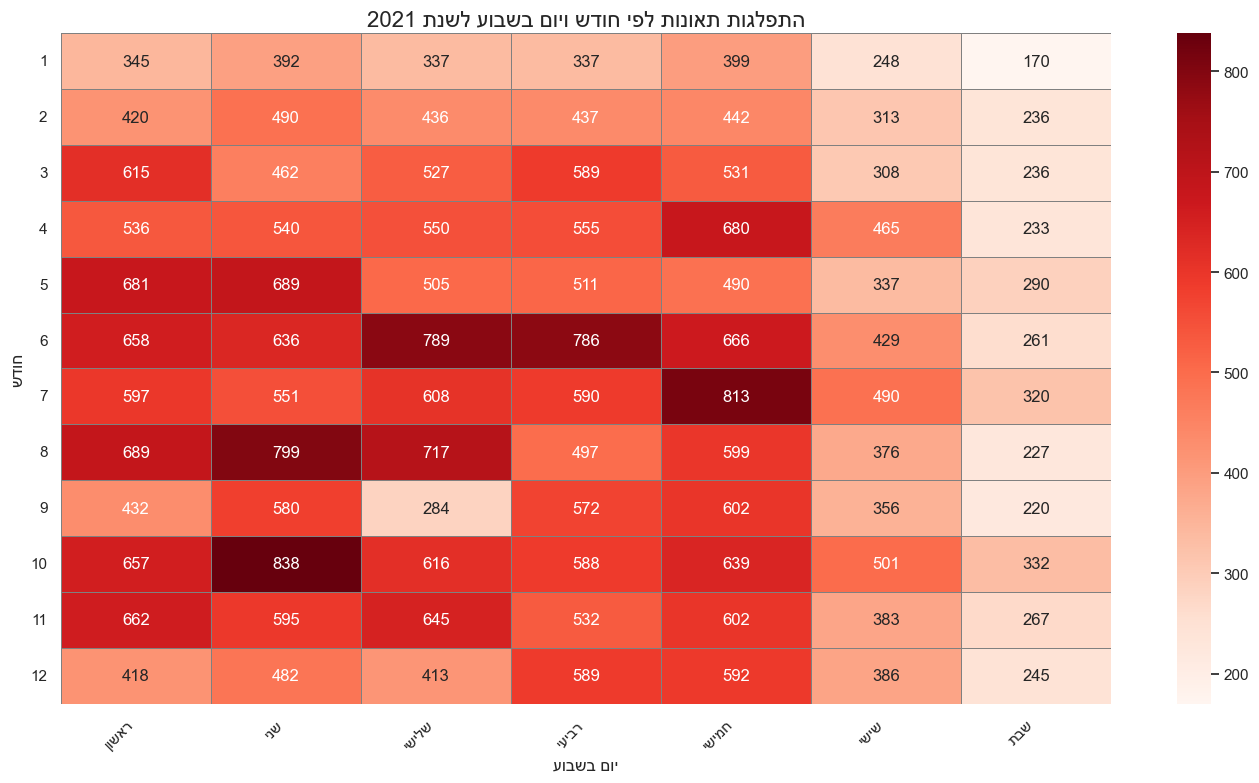

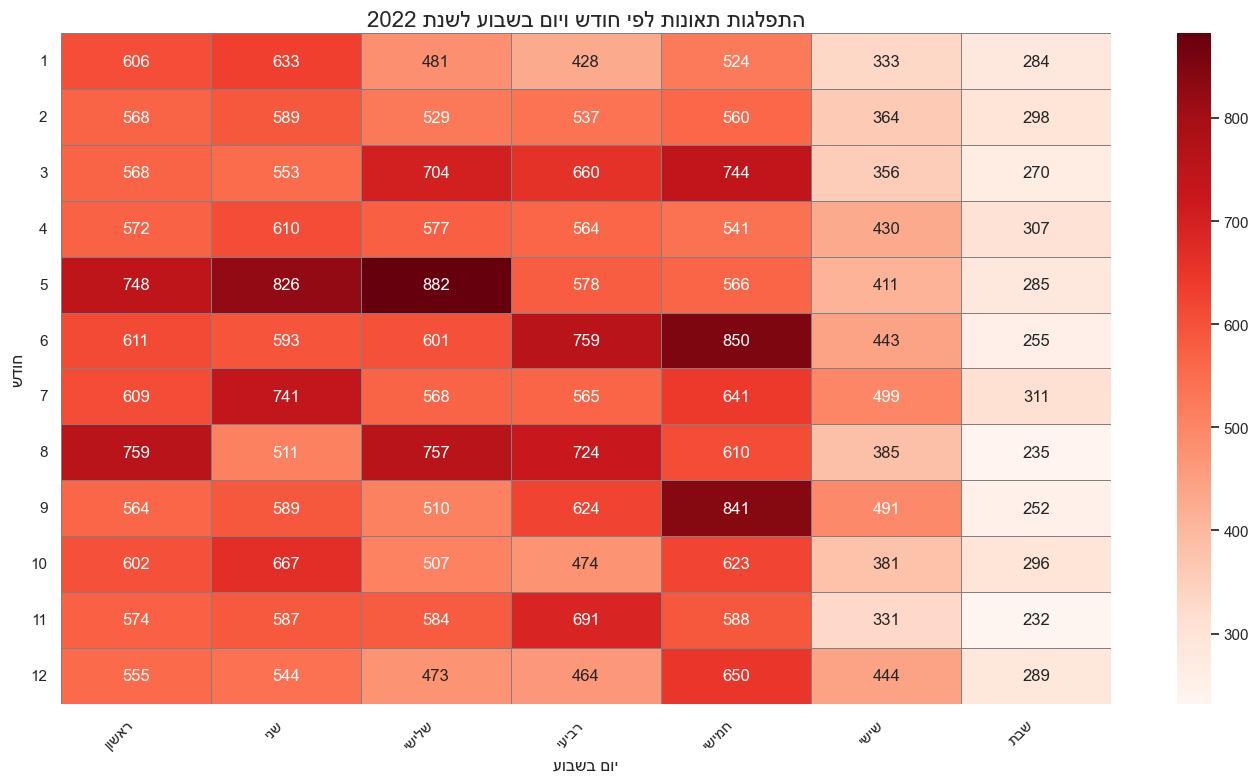

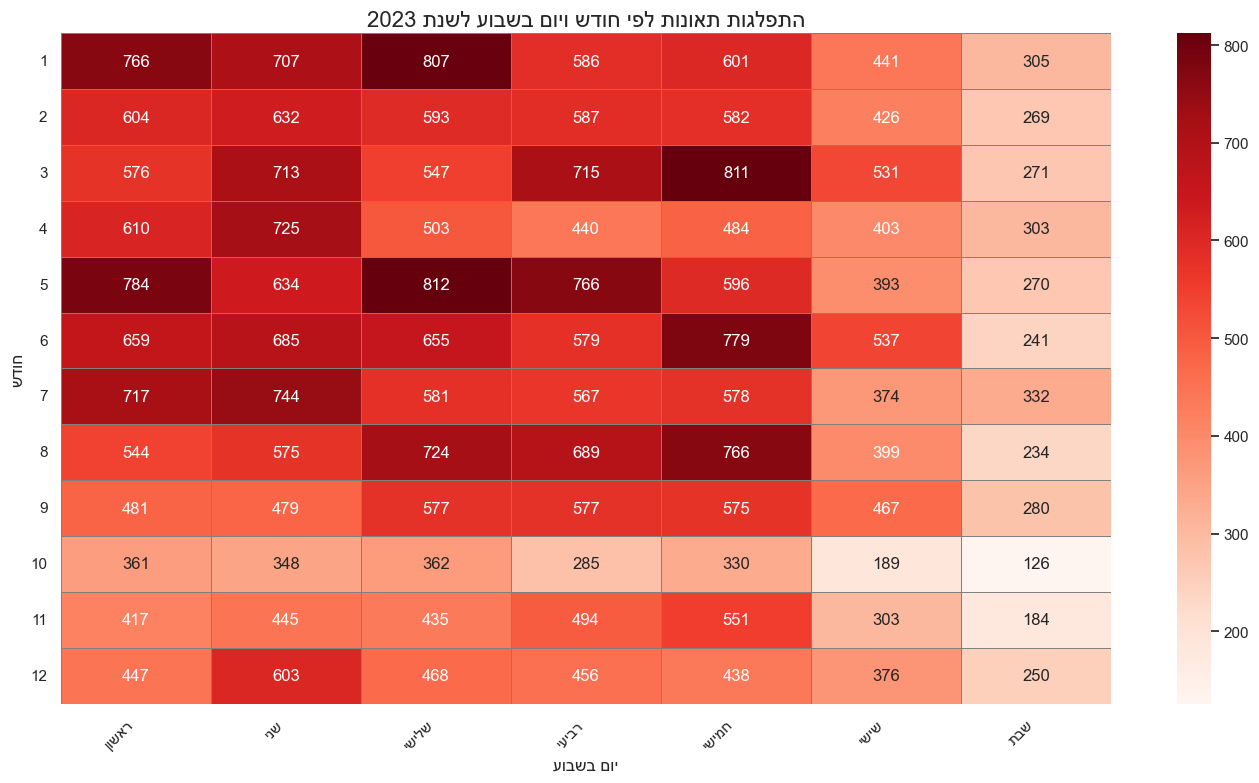

In [94]:

# מיפוי קיצורי ימי השבוע לשמות מלאים
day_map_custom = {
    'ינש': 'ראשון',
    'ןושאר': 'שני',
    'ישילש': 'שלישי',
    'יעיבר': 'רביעי',
    'ישימח': 'חמישי',
    'ישיש': 'שישי',
    'תבש': 'שבת'
}

day_order = ['ראשון', 'שני', 'שלישי', 'רביעי', 'חמישי', 'שישי', 'שבת']

# הנחה: העמודה 'SHNAT_TEUNA_x' מכילה את שנת התאונה
years = sorted(accdata['SHNAT_TEUNA_x'].dropna().unique())

for year in years:
    # סינון לפי שנה
    yearly_data = accdata[accdata['SHNAT_TEUNA_x'] == year]

    # יצירת טבלת heatmap לפי חודש ויום בשבוע (קיצורי ימים)
    heatmap_data = yearly_data.groupby(['HODESH_TEUNA_y', 'YOM_BASHAVUA']).size().unstack(fill_value=0)

    # ממפים את עמודות הימים לשמות מלאים
    heatmap_data.columns = [day_map_custom.get(day, day) for day in heatmap_data.columns]

    # מסדרים את העמודות לפי סדר ימי השבוע
    heatmap_data = heatmap_data.reindex(columns=day_order)

    # עיצוב עברית לעמודות ולשורות
    heatmap_data.columns = [reshape_hebrew(day) for day in heatmap_data.columns]
    heatmap_data.index = [reshape_hebrew(str(month)) for month in heatmap_data.index]

    # ציור הגרף
    plt.figure(figsize=(14, 8))
    ax = sns.heatmap(
        heatmap_data,
        cmap='Reds',
        annot=True,
        fmt='d',
        linewidths=0.5,
        linecolor='gray'
    )

    # תיקון תוויות הצירים אחרי הציור
    ax.set_xticklabels([label.get_text() for label in ax.get_xticklabels()], rotation=45, ha='right')
    ax.set_yticklabels([label.get_text() for label in ax.get_yticklabels()], rotation=0)

    # כותרות
    plt.title(reshape_hebrew(f"התפלגות תאונות לפי חודש ויום בשבוע לשנת {year}"), fontsize=16)
    plt.xlabel(reshape_hebrew("יום בשבוע"))
    plt.ylabel(reshape_hebrew("חודש"))

    plt.tight_layout()
    plt.show()


## ✅ תובנות מהנתונים:
- החודשים עם **מספר התאונות הגבוה ביותר** הם: **מאי (5), יוני (6), יולי (7), ואוגוסט (8)** – אלו חודשי הקיץ והחופשות, המאופיינים בריבוי נסיעות, חופשות משפחתיות, תנועת הולכי רגל רבה יותר, ולעיתים עומסים בכבישים.
- ימי השבוע עם **המספר הגבוה ביותר של תאונות** ברוב החודשים הם **ראשון, וחמישי** – כנראה עקב עומסי תנועה בתחילת שבוע העבודה ובסופו.
- בימי **שבת** נרשמות לרוב פחות תאונות – ייתכן בשל ירידה בפעילות התחבורתית והעדר תחבורה ציבורית.

## 📌 השלכות:
- בחודשי הקיץ יש מקום להגביר את **ההסברה וזהירות בדרכים**, במיוחד לקראת חופשות, טיולים ואירועים.
- בתחילת השבוע ובחמישי נדרשת **אכיפה מוגברת וניהול תנועה חכם**, בפרט באזורים עירוניים ובין־עירוניים מרכזיים.
- ייתכן שנדרש **תכנון עומסים תחבורתיים מחדש** (למשל שעות גמישות למקומות עבודה/חינוך), כדי להפחית את הסיכון באותם ימים רגישים.



#  ניתוח שכיחות סוגי רכבים בתאונות לפי שעת התאונה:

In [97]:
vehicle_hour_analysis = accdata.groupby(['SUG_REHEV_LMS', 'SHAA_CLEAN']).size().unstack(fill_value=0)

peak_hours_df = pd.DataFrame([
    {
        'סוג רכב': vehicle,
        'שעה מסוכנת': f"{vehicle_hour_analysis.loc[vehicle].idxmax()}:00",
        'מספר תאונות': vehicle_hour_analysis.loc[vehicle].max()
    }
    for vehicle in vehicle_hour_analysis.index
])

# מיון לפי מספר תאונות בסדר יורד
peak_hours_df = peak_hours_df.sort_values(by='מספר תאונות', ascending=False)

# יצירת אינדקס חדש עם מספרים רצופים החל מ-1
peak_hours_df.index = range(1, len(peak_hours_df) + 1)
peak_hours_df

סוג רכב שעה מסוכנת  מספר תאונות
1                    רכב נוסעים פרטי      16:00         7290
2                       אחר ולא ידוע      16:00          761
3                            אוטובוס      14:00          654
4              אופנוע 51 עד 125 סמ"ק      14:00          315
5             אופנוע 126 עד 400 סמ"ק      16:00          298
6     משא עד 3.5 טון - אחוד (טרנזיט)      16:00          249
7   משא עד 3.5  טון - לא אחוד (טנדר)      15:00          202
8                   אופנוע 401+ סמ"ק      16:00          189
9                              מונית      15:00          186
10                משא 3.6 עד 9.9 טון      14:00          178
11                   אופניים חשמליים      15:00          144
12              משא 16.0 עד 33.9 טון       8:00          133
13                     קורקינט חשמלי      17:00          111
14                           אופניים      16:00          103
15                      אוטובוס זעיר       8:00           95
16                 אופנוע עד 50 סמ"ק      18:00           61
17                            טרקטור      13:00           51
18              משא 10.0 עד 12.0 טון      10:00           45
19                     משא 34.0+ טון      10:00           44
20              משא 12.1 עד 15.9 טון      10:00           34
21                    קלנועית חשמלית      13:00           21
22                              רכבת      13:00           18
23                         רכב עבודה       8:00           14

---
### <span style="color:green"> Summary</span>

> Anything you'd like to say - your conclusions, summary, how hard you worked etc.
> 
>    
>   
   

---

# ניתוח נתוני תאונות דרכים בישראל – סיכום

## 🚗 1. סוג התאונה מול סוג הדרך

- **מטרת הניתוח:** להבין כיצד סוגי התאונות משתנים בהתאם לסוגי הדרכים (כביש עירוני, בין עירוני).
- **מתודולוגיה:**  
  - סינון וסיווג הנתונים לפי תיעוד סוג התאונה וסוג הכביש.
  - השוואת שכיחות כל סוג תאונה בין סוגי דרכים שונים.
  - ניתוח סטטיסטי לזיהוי מובהקות הבדלים.

- **ממצאים:**
  - **פגיעת אחור** – נצפתה בעיקר בכבישים עירוניים ובשעות עומס, כנראה עקב תנועה צפופה ועיכובים פתאומיים.
  - **התנגשות צד** – נפוצה בצמתים עירוניים עם תנועה רבה ופניות מרובות.
  - **תאונות עם הולכי רגל** – נפוצות בעיקר באיזורים עירוניים.

- **משמעות:**  
  - יש צורך בהתמקדות בהפרדה ברורה של נתיבי תנועה בעיר, שיפור תאורה וציון צמתים מסוכנים.
  - תכנון מחדש של צמתים עירוניים עם התאמה להאטת תנועה ופניות בטוחות.

---

## 📅 2. התפלגות תאונות לפי זמן

- **מטרת הניתוח:** לזהות מתי ולמה מתרחשות התאונות לפי זמנים שונים – ימי השבוע, חודשים, עונות, ושנים.
- **מתודולוגיה:**  
  - איסוף וניתוח הנתונים לפי תאריך ושעה.
  - הצגת הנתונים בגרפים (line charts, heatmaps) להצגת שיאי תאונות.
  - ניתוח מגמות רב-שנתיות (trend analysis).

- **ממצאים:**
  - **ימי חול:** שיעור תאונות גבוה יותר בהשוואה לסופי שבוע, כנראה עקב תנועה עסקית ותנועת עבודה מוגברת.
  - **ימי חמישי וראשון:** זוהו כשיאים בתאונות, ככל הנראה עקב עומסי תנועה בסופי שבוע, חזרה מהחופשות, והיערכות לפסחאות.


- **משמעות:**  
  - שימוש במידע לזיהוי זמנים קריטיים בהם יש להגביר אכיפה וחינוך.
  - אפשרות לתזמן פעילויות מניעה והסברה במועדים רגישים.

---

## 👮 3. כמות תאונות לפי יחידת משטרה ואזור גאוגרפי

- **מטרת הניתוח:** לזהות האם יש פערים משמעותיים בין יחידות משטרה שונות מבחינת נפח ותדירות תאונות.
- **מתודולוגיה:**  
  - מיפוי גאוגרפי של נתוני תאונות לפי אזורי שיפוט.
  - השוואה סטטיסטית בין יחידות.


- **ממצאים:**
  - אזורים עירוניים גדולים הציגו נפח תאונות גבוה במיוחד.
  - ישנם גם אזורים עם מספר תאונות נמוך יחסית, מה שיכול להצביע על שיפור תשתיות ואכיפה.

- **משמעות:**  
  - הפניית משאבים מוגברת לאזורים בעייתיים – תשתיות, אכיפה, חינוך.
  - המלצה להרחבת המיפוי והעדכון התדיר של הנתונים להמשך מעקב.

---

## 🧠 תובנות עיקריות – הרחבה

- **חינוך והסברה:**  
  - פיתוח תכניות הדרכה ממוקדות לנהגים, עם דגש על שמירת מרחק, עירנות בנהיגה, ובעיקר בעיר.
  - קמפיינים תקופתיים המותאמים לזמנים שבהם הסיכון גבוה.

- **שיפור תשתיות:**  
  - שדרוג צמתים ודרכים במיקומים שהוגדרו כנקודות חמות.
  - התקנת רמזורים חכמים, תאורה משופרת, והוספת תשתיות להולכי רגל .

- **אכיפה ממוקדת:**  
  - תכנון אסטרטגי של ניידות משטרתית בזמנים ואזורים רגישים.
  - שימוש במידע סטטיסטי לקביעת מיקומי פקחים ומצלמות מהירות.

- **שימוש בנתונים להחלטות עתידיות:**  
  - הטמעת מערכת ניתוח נתונים חיה שתאפשר זיהוי שינויים ודינמיקה בזמן אמת.
  - שילוב מערכות חכמות ברכבים ובתשתיות עירוניות למניעת תאונות.

---

## 🤝 חוויית העבודה בצוות – פירוט


- **שיתוף פעולה למידה ופיתוח:**  
  - חילופי ידע ות בתחומים שונים חיזקו את ההבנה הכללית.
  - ניתוח ביקורתי של הנתונים והנחות העבודה.
  - דיונים פתוחים שהובילו לשיפורים במודלים ולתיקון טעויות.

- **מיומנויות שהתפתחו:**  
  - עבודה עם כלים מתקדמים לניתוח וויזואליזציה.
  - חיזוק החשיבה האנליטית והביקורתית.
  - פיתוח יכולת הצגה ושכנוע מול קהל.

---

## 🏁 לסיכום מפורט

הפרויקט הצליח לא רק לזהות דפוסים ומגמות מרכזיות בנתוני תאונות הדרכים בישראל, אלא גם להציע פתרונות וצעדים פרקטיים לשיפור הבטיחות בכבישים. העבודה המשותפת אפשרה למצות את הפוטנציאל של הנתונים ולהפוך אותם למידע בעל ערך ממשי לתכנון ולמדיניות ציבורית.

התובנות שהופקו ממחישות את הצורך המשולב בחינוך, תשתיות ואכיפה, כמו גם את הכוח שטמון בניתוח נתונים מתקדם ככלי לקבלת החלטות מושכלות ויעילות.
